In [2]:
import sys
sys.path.append('..')

import utils

C:\Users\desi\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\desi\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
import pandas as pd
import seaborn as sns
import time
import re
from pandas import ExcelWriter
from datetime import datetime
import os
from functools import reduce 
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#### Directory of the file you want to postprocess

In [140]:
os.chdir(r"C:\Users\Desi\Desktop\TesiStanford\keithley_results") # path where the results are stored
#os.chdir(r"C:\Users\Desi\Desktop\TesiStanford\data_to_analyze\GB Keithley")
#os.chdir(r"C:\Users\Desi")
path =  os.getcwd()

#directory = 'Downloads'
directory = '110923-d110623'   
file = 'd110623-4-imp-r1c3-L.xls'
#file = 'd100423-i-r2c4-right-solid-Id-Vg.xlsx'     #downloads

#directory = '031124-d030824'
#file = 'd030824-I-r3c3-R.xls'
#r1c1, r1c2, r3c3R
#directory = '10312023-d102023-w-i'
#file = 'd102023-w-r2c3-left-SolidIdVg.xls' #plus right
#cortisol
#directory = '03042024-d022024-I-DiodeConnected_SensingTest-CT'
#file = '03042024-d022024-I-DiodeConnected_SensingTest-CTr2c2-AS-1uM.xlsx'
#directory = '02082024-d012324-DiodeConnected_SensingTest-AS-Cortisol' #CT-5HT
#file = '02082024-d012324-DiodeConnected_SensingTestr3c2-AS-1uM.xlsx'

# ion sensing
directory = '03012024-d022024-longlegs-DiodeConnected_SensingTest-Na' # name of the directory you want to analyze 
file = '03012024-d022024-longlegs-DiodeConnected_SensingTest-Nar2c2-AS-160mM.xlsx' # name of the file you want to import
directory = '02142024-d012324-DiodeConnected_SensingTest-IonSelectiveK'
file = '02142024-d012324-DiodeConnected_SensingTest-IonSelectiveKr3c2-AS-16mM.xlsx'

# stability
file = '03042024-d022024-Ir2c2-DiodeConnected_StabilityforAptamerSensing-CTr2c2-goodstabilizationBaseline.xlsx'
directory = '03042024-d022024-Ir2c2-DiodeConnected_StabilityforAptamerSensing-CT'


# for diode connection: "C:\Users\Desi\Desktop\TesiStanford\data_to_analyze\GB Keithley\10302023-d10022023-1\d10022023-1-r2c2-photopattern-rightAunp-PBS.xls"

In [142]:
analysis = 'aptamer'
conc = ['baseline','1pM','10pM','100pM','1nM','10nM','100nM','1uM'] if analysis=='aptamer' else ['baseline','1mM','2mM','4mM','8mM','16mM','32mM'] if analysis=='K' else ['baseline','10mM','20mM','40mM','80mM','160mM']

# Postprocessing

In [143]:
k = 8
#conc_ = ['baseline','1pF','10pF','100pF','1nF','10nF','100nF','1uF']

In [144]:
#df = [pd.read_excel(str(os.getcwd())+'\\'+directory+'\\'+file, 'step #'+k) for k in conc[1:k-2]] # for k sensing
#df = [pd.read_excel(str(os.getcwd())+'\\'+directory+'\\'+file, 'step #'+k) for k in conc[1:k]] # for na sensing
df = [pd.read_excel(str(os.getcwd())+'\\'+directory+'\\'+file, 'step #'+str(k)) for k in range(26)] # for stability

In [145]:
# for stabilituìy 
df = [pd.read_excel(str(os.getcwd())+'\\'+directory+'\\'+file, 'step #'+str(k)) for k in range(26)] # for na sensing
df = [i.rename(columns = {'Unnamed: 0': 'datapoint'}).set_index('datapoint') for i in df]
lists_of_df = [[df_conc.iloc[j:j+df_conc.index.max()+1] for i,j in enumerate(range(0, len(df_conc), df_conc.index.max()+1))] for df_conc in df]
diode_dict_list = {}
diode_df_dict = {}
for i,concen in enumerate(range(26)):
    diode_dict_list[concen] = lists_of_df[i]
    diode_df_dict[concen] = pd.concat(lists_of_df[i])

In [124]:
# in case of read_xls - setting the Unnamed: 0 column as index and creating again a list of df
df = [i.rename(columns = {'Unnamed: 0': 'datapoint'}).set_index('datapoint') for i in df]
lists_of_df = [[df_conc.iloc[j:j+df_conc.index.max()+1] for i,j in enumerate(range(0, len(df_conc), df_conc.index.max()+1))] for df_conc in df]


In [125]:
diode_dict_list = {}
diode_df_dict = {}
for i,concen in enumerate(conc[1:k-2]):
    diode_dict_list[concen] = lists_of_df[i]
    diode_df_dict[concen] = pd.concat(lists_of_df[i])

#### Defining the mean and the std for |VDl-VDR|, VDR and VDL, for the last Nvalues of the last Nsubgroup steps

In [146]:
Nsubgroup = 6
Nvalues = 5

mean_std = [[np.mean([(subdf['VDL'].iloc[-Nvalues:]-subdf['VDR'].iloc[-Nvalues:]).values for subdf in diode_df[-Nsubgroup:]]),np.std(np.mean([abs(subdf['VDL'].iloc[-Nvalues:]-subdf['VDR'].iloc[-Nvalues:]).values for subdf in diode_df[-Nsubgroup:]],1))] for diode_df in lists_of_df]
mean_std_L = [[np.mean([subdf['VDL'].iloc[-Nvalues:].values for subdf in df_conc[-Nsubgroup:]]),np.std(np.mean([subdf['VDL'].iloc[-Nvalues:].values for subdf in df_conc[-Nsubgroup:]],1))] for df_conc in lists_of_df]
mean_std_R = [[np.mean([subdf['VDR'].iloc[-Nvalues:].values for subdf in df_conc[-Nsubgroup:]]),np.std(np.mean([subdf['VDR'].iloc[-Nvalues:].values for subdf in df_conc[-Nsubgroup:]],1))] for df_conc in lists_of_df]

# subtracting the baseline to all the mean_std
mean_std = [[(i[0]-mean_std[0][0])*1000,i[1]*1000] for i in mean_std]
mean_std_L = [[(i[0]-mean_std_L[0][0])*1000,i[1]*1000] for i in mean_std_L]
mean_std_R = [[(i[0]-mean_std_R[0][0])*1000,i[1]*1000] for i in mean_std_R]

#mean_std = [[(i[0]-mean_std[0][0]),i[1]] for i in mean_std]
#mean_std_L = [[(i[0]-mean_std_L[0][0]),i[1]] for i in mean_std_L]
#mean_std_R = [[(i[0]-mean_std_R[0][0]),i[1]] for i in mean_std_R]

#### Creating a dataframe with all the mean and std

In [190]:
mean_std = pd.DataFrame(mean_std).rename(columns={0: 'mean [V]', 1: 'std [V]'})
mean_std['mean_L [V]'] = [i[0]-mean_std_L[0][0] for i in mean_std_L]
mean_std['std_L [V]'] = [i[1] for i in mean_std_L]
mean_std['mean_R [V]'] = [i[0]-mean_std_R[0][0] for i in mean_std_R]
mean_std['std_R [V]'] = [i[1] for i in mean_std_R]

In [38]:
path = "C:\Users\Desi\Desktop\TesiStanford\keithley_results"
directory = '\02142024-d012324-DiodeConnected_SensingTest-IonSelectiveK'
file_name = '\mean_std_d012324-r3c2-Ksensing'
mean_std.to_excel(path+directory+file_name+'.xlsx')

# End of postprocessing

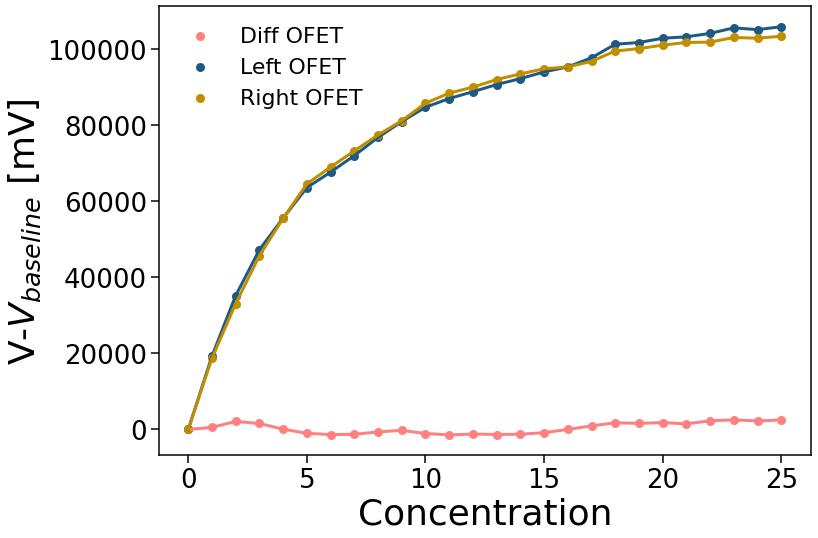

In [16]:
utils.plot_mean_std(26, mean_std_L,mean_std_R, [[(i[0]),i[1]] for i in mean_std], range(26), 'r2c2')

In [15]:
# for the K sensing
#mean_std_ = [[i[0] - mean_std[1][0],i[1]] for i in mean_std]
#conc = conc[1:]
conc = conc[-1:]

In [16]:
conc

['160mM']

In [13]:
conc_na = np.log10(np.array([10,20,40,80,160]))

In [171]:
#y = (x-x1)/(x2-x1) * (y2-y1) + y1
y = (2-conc_na[0])/(conc_na[-1]-conc_na[0]) * (line[-1]-line[0])+line[0]
print('Sensitivity per decade of concenreation Na:',y-line[0])

Sensitivity per decade of concenreation Na -11.245833910558703


In [287]:
#y = (x-x1)/(x2-x1) * (y2-y1) + y1
y = (1-conc_k[0])/(conc_k[-1]-conc_k[0]) * (line[-1]-line[0])+line[0]
print('Sensitivity per decade of concenreation Na:',y-line[0])

Sensitivity per decade of concenreation Na: 40.973768431705665


In [288]:
y

42.00843509837234

### Na

In [91]:
mean_std_L_na = mean_std_L
mean_std_R_na = mean_std_R
mean_std_na = mean_std

In [138]:
import math
#fig, ax = plt.subplots(figsize = (11.69,8.26))
gao = [0.17,0.182,0.205,0.225,0.245]
gao = [i - gao[0] for i in gao]
#ax.set_xscale('log')
#plt.scatter(np.log10([1,2,4,8,16]),gao)

coefficients = np.polyfit(conc_na, abs(np.array([i[0]-mean_std_na[0][0] for i in mean_std_na])), 1)
m, q = coefficients

# Calcolare la retta di regressione
line = m * conc_na + q
# Calcolare il coefficiente di correlazione (R-squared)
correlation_matrix = np.corrcoef(conc_na,  abs(np.array([i[0]-mean_std_na[0][0] for i in mean_std_na])))
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print("R-squared:", r_squared)

R-squared: 0.966657944555866


In [133]:
conc = 10**conc_na
conc

array([ 10.,  20.,  40.,  80., 160.])

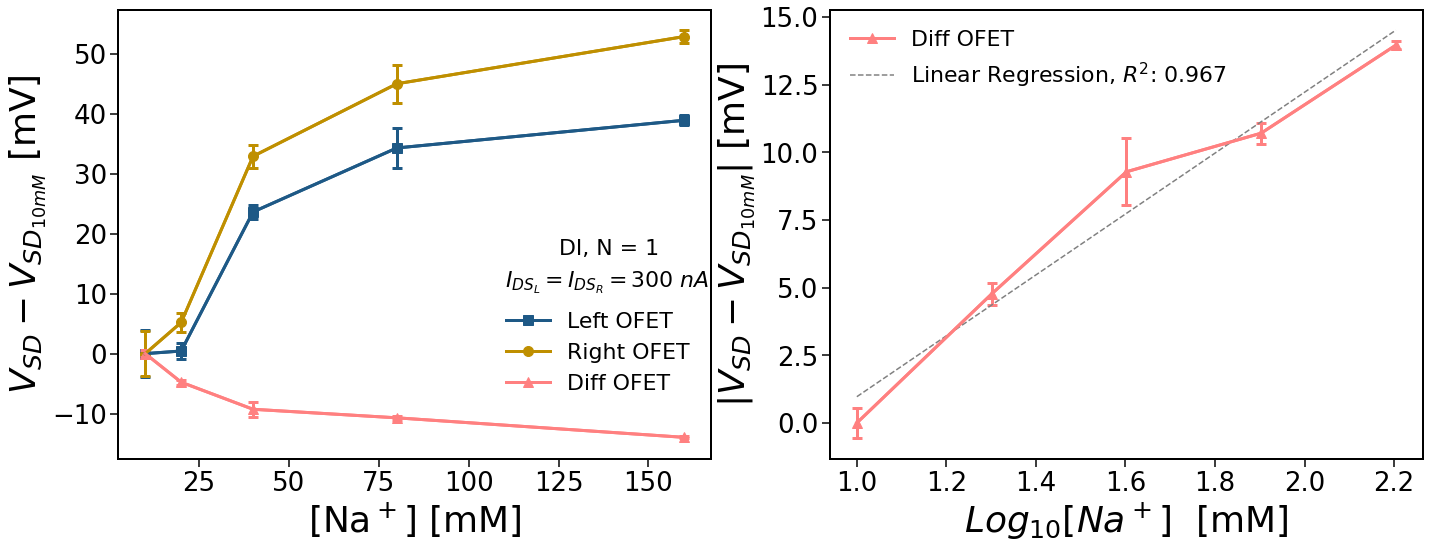

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23.38, 8.26), sharey=False)  # 2 subplots, 1 row, 2 columns
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_linewidth(2) # width of the margins
    ax.tick_params(axis='both', width=1.5, length=8, labelsize=26)

L = [i[0] - mean_std_L_na[0][0] for i in mean_std_L_na]
R = [i[0] - mean_std_R_na[0][0] for i in mean_std_R_na]
# NA ['10','20','40','80','160']

# left plot
ax1.plot(conc, L , color = col_L, linewidth = 3, label='Left OFET', marker = 's', markersize= 10)
ax1.errorbar(conc, L, yerr=[i[1] for i in mean_std_L_na], color = col_L, linewidth = 3, capsize = 5,capthick = 3)
ax1.plot(conc, R , color = col_R, linewidth = 3, label='Right OFET', marker = 'o', markersize= 10)
ax1.errorbar(conc, R, yerr=[i[1] for i in mean_std_R_na], color = col_R, linewidth = 3, capsize = 5,capthick = 3)
ax1.plot(conc, [i[0] for i in mean_std_na], color = col_diff , linewidth = 3, label='Diff OFET', marker = '^', markersize= 10)
ax1.errorbar(conc, [i[0] for i in mean_std_na], yerr=[i[1] for i in mean_std_na], color = col_diff, linewidth = 3, capsize = 5,capthick = 3)

ax1.text(125, 16.5, 'DI, N = 1', fontsize = 22)
ax1.text(110, 11, '$I_{DS_L} = I_{DS_R} = 300\ nA$', fontsize = 22)
ax1.set_xlabel('[Na$^+$] [mM]', fontsize = 36)
ax1.set_ylabel('$V_{SD} - V_{SD_{10mM}}$ [mV]', fontsize = 36)
ax1.legend(bbox_to_anchor=[0.62, 0.1],  fontsize=22, frameon=False)        

# right plot     
ax2.plot(conc_na, abs(np.array([i[0]-mean_std_na[0][0] for i in mean_std_na])), color = col_diff, linewidth = 3, label = 'Diff OFET', marker = '^', markersize= 10)
ax2.errorbar(conc_na, abs(np.array([i[0]-mean_std_na[0][0] for i in mean_std_na])), yerr=[i[1]-mean_std_na[0][0] for i in mean_std_na], color = col_diff, linewidth = 3, capsize = 5, capthick = 3)
ax2.plot(conc_na, line, '--', label='Linear Regression, $R^2$: '+str(round(r_squared,3)), color = 'grey')

ax2.set_xlabel('$Log_{10}[Na^+]$  [mM]', fontsize = 36)
ax2.set_ylabel('$|V_{SD} - V_{SD_{10mM}}|$ [mV]', fontsize = 36)
#plt.title('Mean and Std DeltaV dor different concentrartions (last 5 values of the last 6 steps)')
ax2.legend(loc = 'upper left',fontsize=22, frameon=False)
plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\Na-Allsensing_1200.jpeg",bbox_inches='tight', dpi = 1200)

### K

In [127]:
conc_k = np.log10(np.array([1,2,4,8,16]))

In [128]:
import math
#fig, ax = plt.subplots(figsize = (11.69,8.26))
gao = [0.17,0.182,0.205,0.225,0.245]
gao = [i - gao[0] for i in gao]
#ax.set_xscale('log')
#plt.scatter(np.log10([1,2,4,8,16]),gao)

coefficients = np.polyfit(conc_k, abs(np.array([i[0]-mean_std[0][0] for i in mean_std])), 1)
m, q = coefficients

# Calcolare la retta di regressione
line = m * conc_k + q
# Calcolare il coefficiente di correlazione (R-squared)
correlation_matrix = np.corrcoef(conc_k,  abs(np.array([i[0]-mean_std[0][0] for i in mean_std])))
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

In [129]:
conc = [1,2,4,8,16]

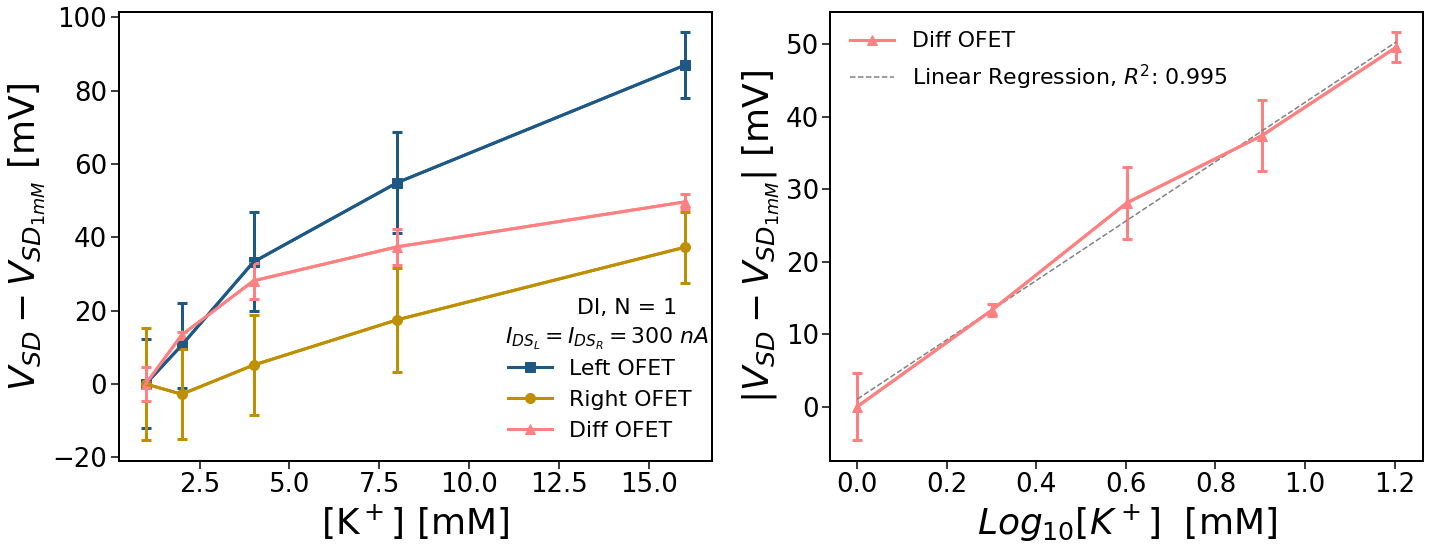

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23.38, 8.26), sharey=False)  # 2 subplots, 1 row, 2 columns
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_linewidth(2) # width of the margins
    ax.tick_params(axis='both', width=1.5, length=8, labelsize=26)

L = [i[0] - mean_std_L[0][0] for i in mean_std_L]
R = [i[0] - mean_std_R[0][0] for i in mean_std_R]
# NA ['10','20','40','80','160']

# left plot
ax1.plot(conc, L , color = col_L, linewidth = 3, label='Left OFET', marker = 's', markersize= 10)
ax1.errorbar(conc, L, yerr=[i[1] for i in mean_std_L], color = col_L, linewidth = 3, capsize = 5,capthick = 3)
ax1.plot(conc, R , color = col_R, linewidth = 3, label='Right OFET', marker = 'o', markersize= 10)
ax1.errorbar(conc, R, yerr=[i[1] for i in mean_std_R], color = col_R, linewidth = 3, capsize = 5,capthick = 3)
ax1.plot(conc, [i[0] for i in mean_std], color = col_diff , linewidth = 3, label='Diff OFET', marker = '^', markersize= 10)
ax1.errorbar(conc, [i[0] for i in mean_std], yerr=[i[1] for i in mean_std], color = col_diff, linewidth = 3, capsize = 5,capthick = 3)

ax1.text(13, 19, 'DI, N = 1', fontsize = 22)
ax1.text(11, 11, '$I_{DS_L} = I_{DS_R} = 300\ nA$', fontsize = 22)
ax1.set_xlabel('[K$^+$] [mM]', fontsize = 36)
ax1.set_ylabel('$V_{SD} - V_{SD_{1mM}}$ [mV]', fontsize = 36)
ax1.legend(loc = 'lower right',  fontsize=22, frameon=False)        

# right plot     
ax2.plot(conc_k, abs(np.array([i[0]-mean_std[0][0] for i in mean_std])), color = col_diff, linewidth = 3, label = 'Diff OFET', marker = '^', markersize= 10)
ax2.errorbar(conc_k, abs(np.array([i[0]-mean_std[0][0] for i in mean_std])), yerr=[i[1]-mean_std[0][0] for i in mean_std], color = col_diff, linewidth = 3, capsize = 5, capthick = 3)
ax2.plot(conc_k, line, '--', label='Linear Regression, $R^2$: '+str(round(r_squared,3)), color = 'grey')

ax2.set_xlabel('$Log_{10}[K^+]$  [mM]', fontsize = 36)
ax2.set_ylabel('$|V_{SD} - V_{SD_{1mM}}|$ [mV]', fontsize = 36)
#plt.title('Mean and Std DeltaV dor different concentrartions (last 5 values of the last 6 steps)')
ax2.legend(loc = 'upper left',fontsize=22, frameon=False)
plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\K-Allsensing_1200.jpeg",bbox_inches='tight', dpi = 1200)

In [406]:
conc

['baseline', '1pM', '10pM', '100pM', '1nM', '10nM', '100nM', '1uM']

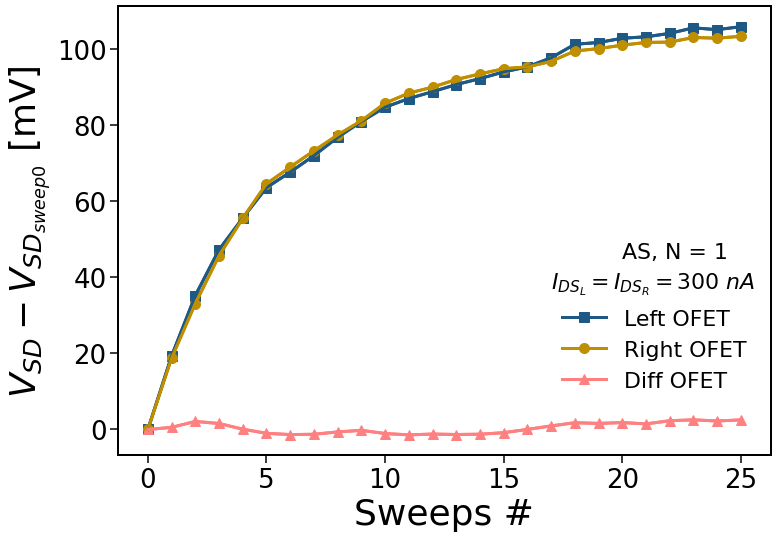

In [148]:
#conc_ = conc
col_L = '#1E5986'
col_R = '#BF8F00'
col_diff = "#FF8080"
fig, ax = plt.subplots(figsize = (11.69,8.26))
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)


ax.tick_params(axis='both', width=1.5, length=8, labelsize=26)

L = [i[0] - mean_std_L[0][0] for i in mean_std_L]
R = [i[0] - mean_std_R[0][0] for i in mean_std_R]
# NA ['10','20','40','80','160']

plt.plot(range(26), L , color = col_L, linewidth = 3, label='Left OFET', marker = 's', markersize= 10)
plt.errorbar(range(26), L, yerr=[i[1] for i in mean_std_L], color = col_L, linewidth = 3)
plt.plot(range(26), R , color = col_R, linewidth = 3, label='Right OFET', marker = 'o', markersize= 10)
plt.errorbar(range(26), R, yerr=[i[1] for i in mean_std_R], color = col_R, linewidth = 3)
plt.plot(range(26), [i[0] for i in mean_std], color = col_diff , linewidth = 3, label='Diff OFET', marker = '^', markersize= 10)
plt.errorbar(range(26), [i[0] for i in mean_std], yerr=[i[1] for i in mean_std], color = col_diff, linewidth = 3)

plt.text(20, 45, 'AS, N = 1', fontsize = 22)
plt.text(17, 37, '$I_{DS_L} = I_{DS_R} = 300\ nA$', fontsize = 22)
plt.xlabel('Sweeps #', fontsize = 36)
plt.ylabel('$V_{SD} - V_{SD_{sweep0}}$ [mV]', fontsize = 36)
plt.legend(bbox_to_anchor=(0.65, 0.1),  fontsize=22, frameon=False)
plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\StabilizationBeforeSensing_1200.jpeg",bbox_inches='tight', dpi = 1200)
#plt.title('Mean and Std DeltaV dor different concentrartions (last 5 values of the last 6 steps)')


In [174]:
10**np.array(conc_na)

array([ 10.,  20.,  40.,  80., 160.])

## Na plot

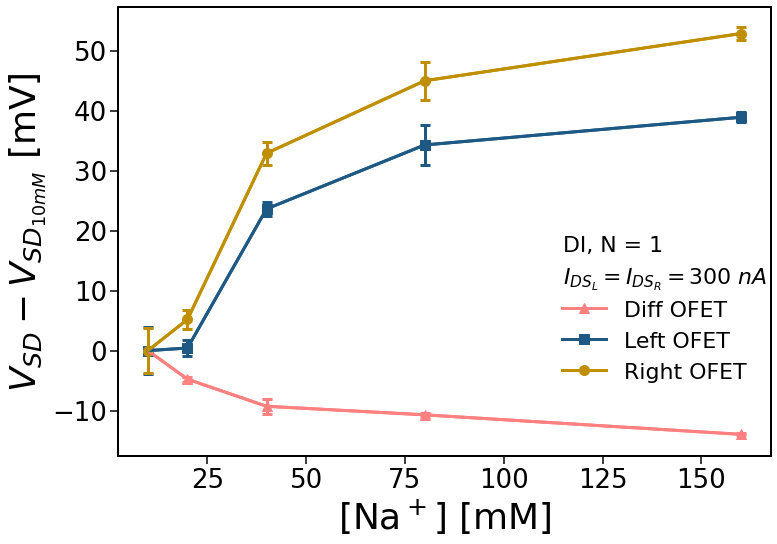

In [43]:
col_L = '#1E5986'
col_R = '#BF8F00'
col_diff = "#FF8080"
conc = 10**np.array(conc_na)
fig, ax = plt.subplots(figsize = (11.69,8.26)) # plot dimensions

#width of the margins
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)


ax.tick_params(axis='both', width=1.5, length=8, labelsize=26)

L = [i[0] - mean_std_L[0][0] for i in mean_std_L]
R = [i[0] - mean_std_R[0][0] for i in mean_std_R]
# NA ['10','20','40','80','160']
plt.plot(conc, [i[0] for i in mean_std], color = col_diff , linewidth = 3, label='Diff OFET', marker = '^', markersize= 10)
plt.errorbar(conc, [i[0] for i in mean_std], yerr=[i[1] for i in mean_std], color = col_diff, linewidth = 3, capsize = 5,capthick = 3)
plt.plot(conc, L , color = col_L, linewidth = 3, label='Left OFET', marker = 's', markersize= 10)
plt.errorbar(conc, L, yerr=[i[1] for i in mean_std_L], color = col_L, linewidth = 3, capsize = 5,capthick = 3)
plt.plot(conc, R , color = col_R, linewidth = 3, label='Right OFET', marker = 'o', markersize= 10)
plt.errorbar(conc, R, yerr=[i[1] for i in mean_std_R], color = col_R, linewidth = 3, capsize = 5,capthick = 3)
plt.text(115, 16.5, 'DI, N = 1', fontsize = 22)
plt.text(115, 11, '$I_{DS_L} = I_{DS_R} = 300\ nA$', fontsize = 22)
plt.xlabel('[Na$^+$] [mM]', fontsize = 36)
plt.ylabel('$V_{SD} - V_{SD_{10mM}}$ [mV]', fontsize = 36)
plt.legend(bbox_to_anchor=[0.65, 0.12],  fontsize=22, frameon=False)
plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\Na-sensing_1200.jpeg",bbox_inches='tight', dpi = 1200)
#plt.title('Mean and Std DeltaV dor different concentrartions (last 5 values of the last 6 steps)')


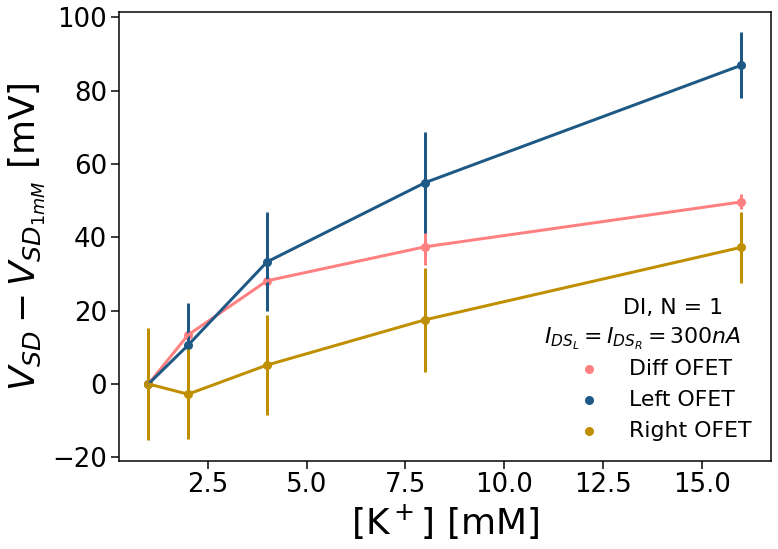

In [284]:
col_L = '#1E5986'
col_R = '#BF8F00'
col_diff = "#FF8080"
conc = 10**np.array(conc_k)
fig, ax = plt.subplots(figsize = (11.69,8.26))
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)


ax.tick_params(axis='both', width=1.5, length=8, labelsize=26)

L = [i[0] - mean_std_L[0][0] for i in mean_std_L]
R = [i[0] - mean_std_R[0][0] for i in mean_std_R]
# NA ['10','20','40','80','160']
plt.scatter(conc, [i[0] for i in mean_std], color = col_diff , linewidth = 3, label='Diff OFET')
plt.errorbar(conc, [i[0] for i in mean_std], yerr=[i[1] for i in mean_std], color = col_diff, linewidth = 3)
plt.scatter(conc, L , color = col_L, linewidth = 3, label='Left OFET')
plt.errorbar(conc, L, yerr=[i[1] for i in mean_std_L], color = col_L, linewidth = 3)
plt.scatter(conc, R , color = col_R, linewidth = 3, label='Right OFET')
plt.errorbar(conc, R, yerr=[i[1] for i in mean_std_R], color = col_R, linewidth = 3)
plt.text(13, 19, 'DI, N = 1', fontsize = 22)
plt.text(11, 11, '$I_{DS_L} = I_{DS_R} = 300 nA$', fontsize = 22)
plt.xlabel('[K$^+$] [mM]', fontsize = 36)
plt.ylabel('$V_{SD} - V_{SD_{1mM}}$ [mV]', fontsize = 36)
plt.legend(loc = 'lower right',  fontsize=22, frameon=False)
plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\K-sensing.jpeg",bbox_inches='tight')
#plt.title('Mean and Std DeltaV dor different concentrartions (last 5 values of the last 6 steps)')


In [228]:
mean_std_L_na = mean_std_L
mean_std_R_na = mean_std_R
mean_std_na = mean_std

In [173]:
conc_na

array([1.        , 1.30103   , 1.60205999, 1.90308999, 2.20411998])

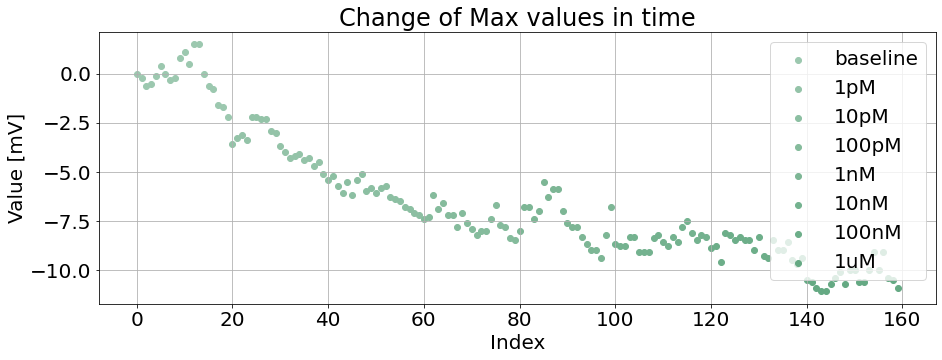

In [426]:
utils.plot_max_values(diode_df_dict, conc, 'r1c2','baseline','','', mode = 1)

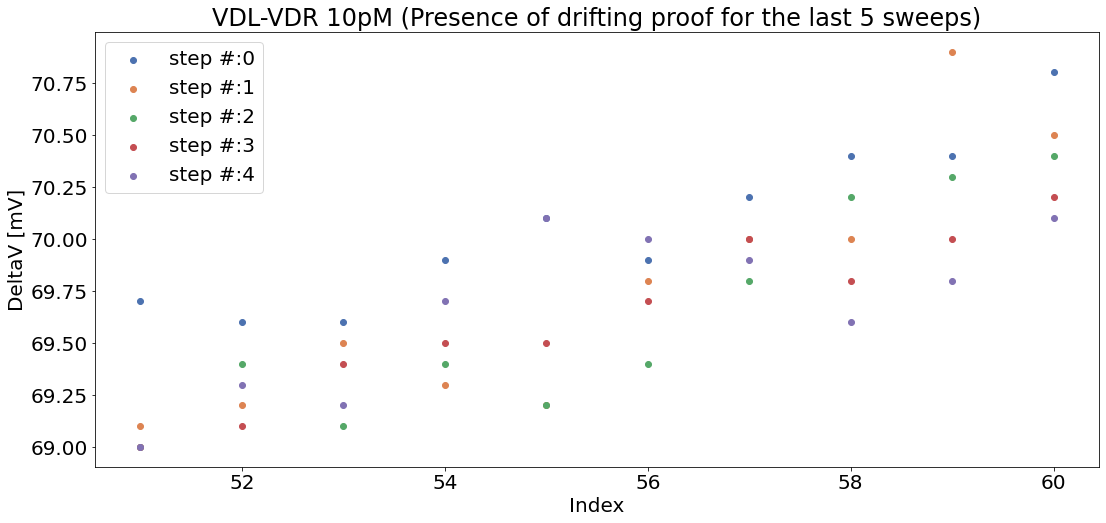

In [427]:
# plotting the 20 steps for the specific concentration
colors_diff_step = sns.color_palette("deep",20)
concentration = conc[2]
subset_dfs = diode_dict_list[concentration]

fig, ax = plt.subplots(figsize = (18,8))
for i,df in enumerate(subset_dfs[-5:]):
    ax.scatter(df.index[-10:], (df.iloc[-10:]['VDL']-df[-10:]['VDR'])*1000, label = 'step #:'+str(i), color = colors_diff_step[i])


ax.set_xlabel('Index')
ax.set_ylabel('DeltaV [mV]')
ax.legend()
plt.title('VDL-VDR ' + concentration + ' (Presence of drifting proof for the last 5 sweeps)')
plt.show()

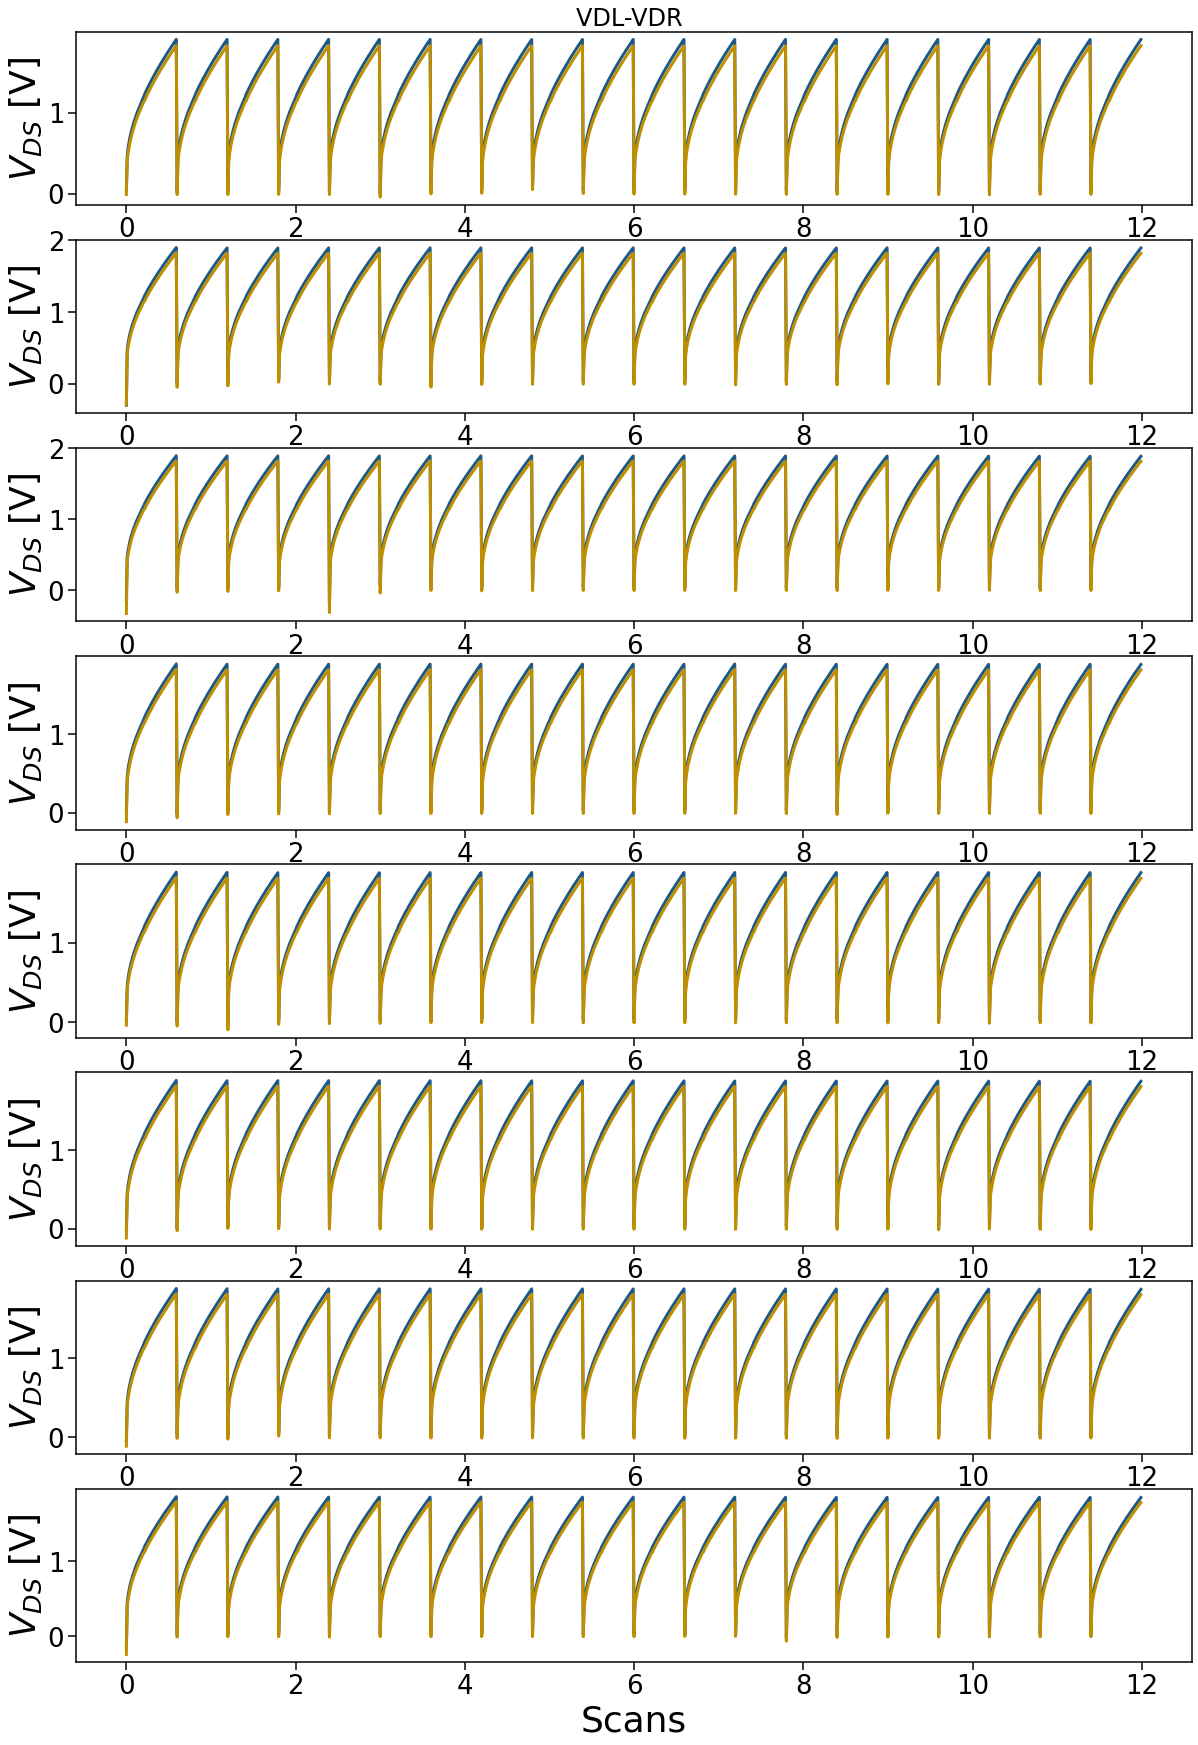

In [428]:
fig, ax = plt.subplots(len(conc),1,figsize = (20,30))

ax[0].set_title('VDL-VDR ')
for nu in range(len(conc)):
    ax[nu].tick_params(axis='both', width=1.5, length=8, labelsize=26)
    ax[nu].spines['bottom'].set_linewidth(1.5)
    ax[nu].spines['top'].set_linewidth(1.5)
    ax[nu].spines['left'].set_linewidth(1.5)
    ax[nu].spines['right'].set_linewidth(1.5)

    ax[nu].plot(np.arange(0,12,12/len(diode_df_dict[conc[nu]].reset_index().index)), (diode_df_dict[conc[nu]]['VDL']), label = 'Left OFET', linewidth = 3, color = col_L)
    ax[nu].plot(np.arange(0,12,12/len(diode_df_dict[conc[nu]].reset_index().index)), (diode_df_dict[conc[nu]]['VDR']), label = 'Right OFET', linewidth = 3, color = col_R)

    #ax[nu].plot(diode_df_dict[conc[nu]].reset_index().index, (diode_df_dict[conc[nu]]['VDL']-diode_df_dict[conc[nu]]['VDR'])*1000, label = 'L-R'+str(conc[nu]))
    ax[nu].set_xlabel('Scans', fontsize = 36)
    ax[nu].set_ylabel('$V_{DS}$ [V]', fontsize = 36)
    #ax[nu].legend( fontsize=22, frameon=False)
    

#plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\20sweeps.jpg")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyError: '32mM'

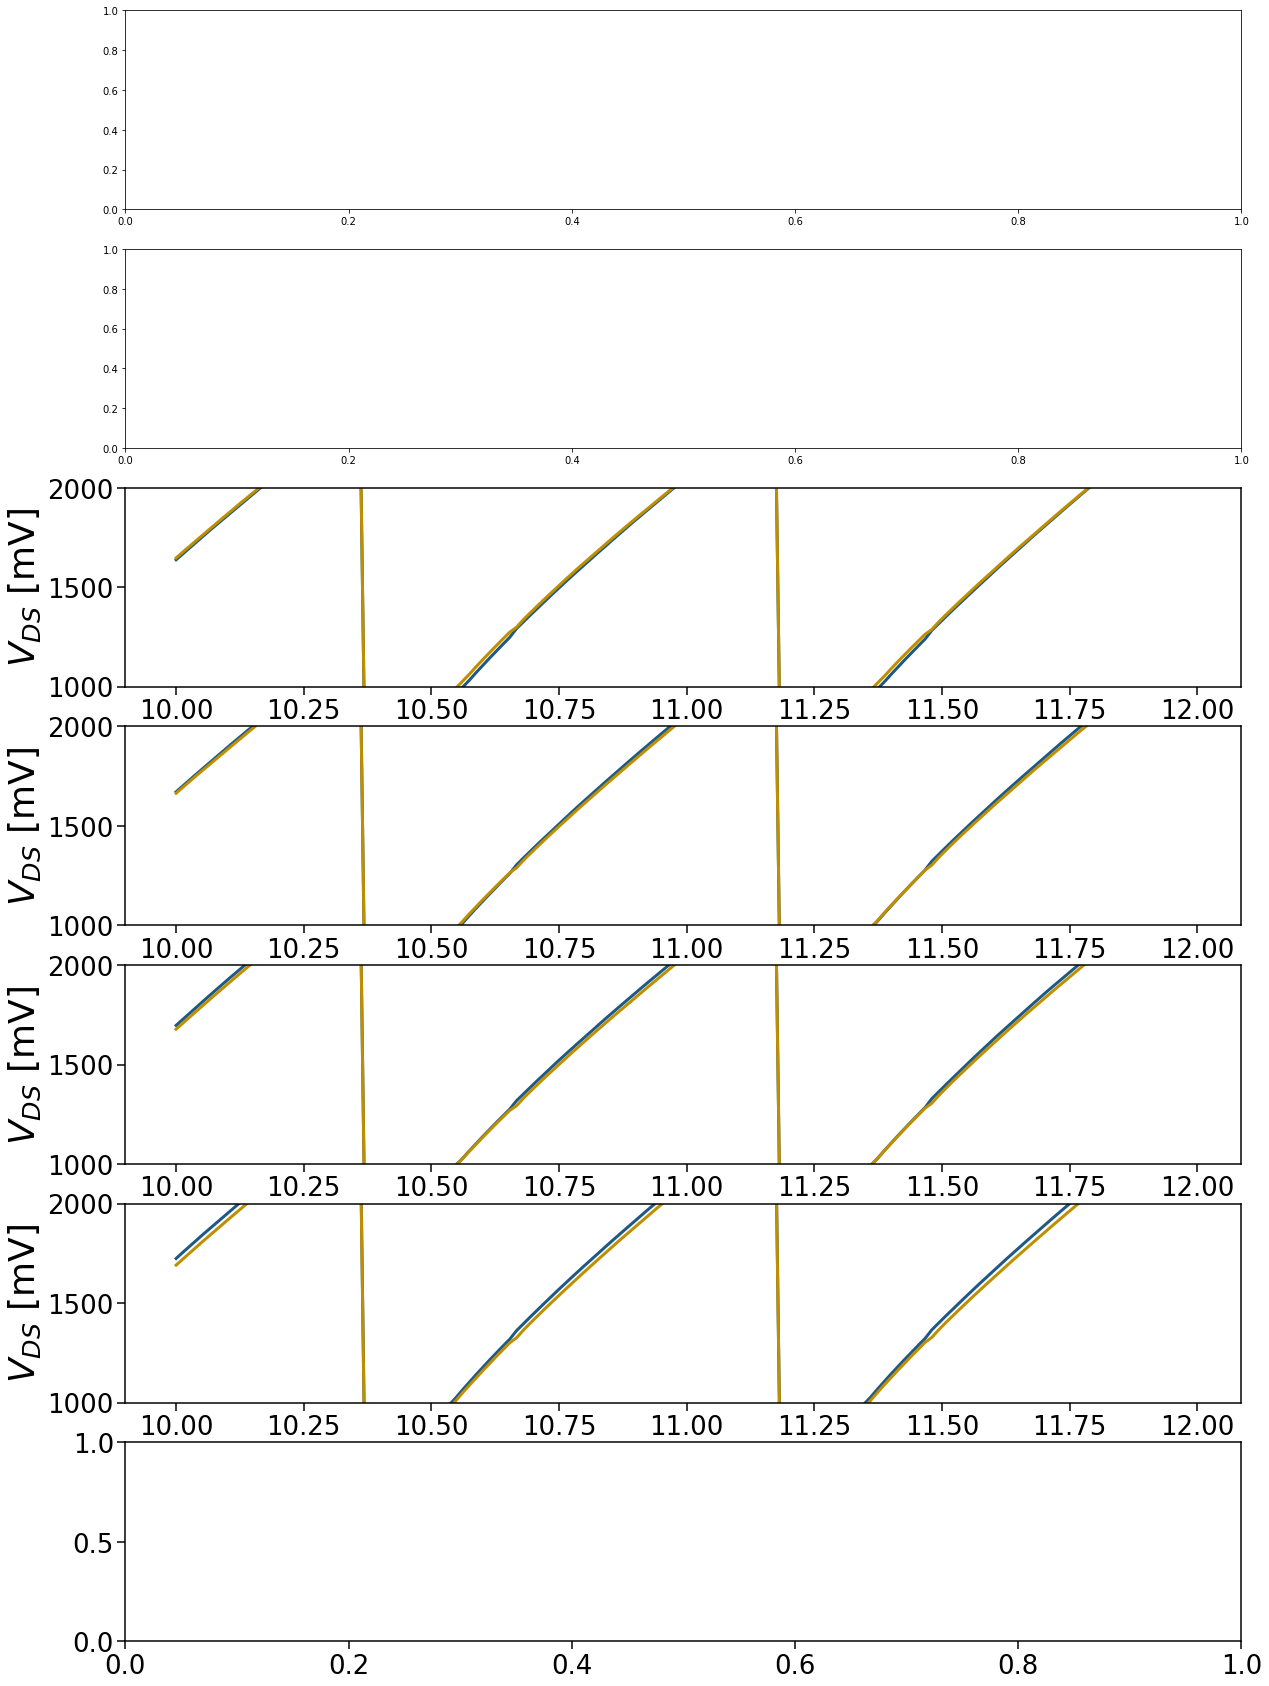

In [304]:
fig, ax = plt.subplots(len(conc),1,figsize = (20,30))
#ax[0].set_title('VDL-VDR ')
for nu in range(2,len(conc)):
    ax[nu].tick_params(axis='both', width=1.5, length=8, labelsize=26)
    ax[nu].spines['bottom'].set_linewidth(1.5)
    ax[nu].spines['top'].set_linewidth(1.5)
    ax[nu].spines['left'].set_linewidth(1.5)
    ax[nu].spines['right'].set_linewidth(1.5)
    #ax[nu].scatter(diode_df_dict[conc[nu]].iloc[-300:].reset_index().index, (diode_df_dict[conc[nu]]['VDL'].iloc[-300:])*1000, label = 'L:'+str(conc[nu]), linewidth = 3, color = col_L)
    ax[nu].plot(np.arange(10,12,2/len(diode_df_dict[conc[nu]].iloc[-150:].reset_index().index)), (diode_df_dict[conc[nu]]['VDL'].iloc[-150:])*1000, label = 'Left OFET', linewidth = 3, color = col_L)
    ax[nu].plot(np.arange(10,12,2/len(diode_df_dict[conc[nu]].iloc[-150:].reset_index().index)), (diode_df_dict[conc[nu]]['VDR'].iloc[-150:])*1000, label = 'Right OFET', linewidth = 3, color = col_R)

    #ax[nu].plot(diode_df_dict[conc[nu]].reset_index().index, (diode_df_dict[conc[nu]]['VDL']-diode_df_dict[conc[nu]]['VDR'])*1000, label = 'L-R'+str(conc[nu]))
    ax[nu].set_ylim([1000, 2000])
    #ax[nu].set_xlabel('Sweeps', fontsize = 36)
    ax[nu].set_ylabel('$V_{DS}$ [mV]', fontsize = 36)
    ax[0].legend( fontsize=22, frameon=False)

#plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\5_Zoom_sweepsK_legend.jpg")
plt.show()

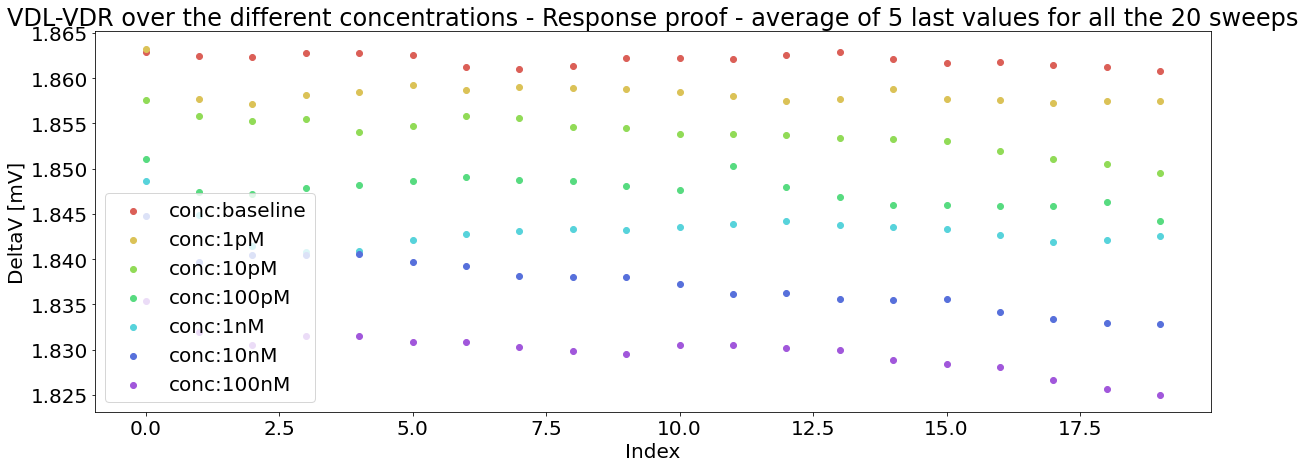

In [432]:
fig, ax = plt.subplots(figsize = (20,7))
colors_diff = sns.color_palette("hls", 8)
for i,conce in enumerate(conc[:-1]):
    medie_gruppi = []
    lista_numeri = diode_df_dict[conce][diode_df_dict[conce].index.isin(range(55, 61))]['VDL']
    dimensione_gruppo = 6
    for j in range(0, len(lista_numeri), dimensione_gruppo):
        gruppo = lista_numeri[j:j+dimensione_gruppo]
        media_gruppo = sum(gruppo) / len(gruppo)
        medie_gruppi.append(media_gruppo)
    
    #ax.scatter(range(0,20), (diode_df_dict[conce][diode_df_dict[conce].index == 60]['VDL']-diode_df_dict[conce][diode_df_dict[conce].index == 60]['VDR'])*1000, label = 'conc:'+conc[i], color = colors_diff[i])
    ax.scatter(range(0,20), medie_gruppi, label = 'conc:'+conc[i], color = colors_diff[i])
ax.set_xlabel('Index')
ax.set_ylabel('DeltaV [mV]')
ax.legend()
plt.title('VDL-VDR over the different concentrations - Response proof - average of 5 last values for all the 20 sweeps')
plt.show()

In [433]:
# taking the last 5 sweeps and took the average of all the curves
average_5sweeps = pd.DataFrame()
average_5sweeps_diff = pd.DataFrame()
for concen in conc: 
    average_5sweeps[concen] = np.mean(pd.concat([i['VDL']*1000 for i in diode_dict_list[concen][15:]], axis = 1),axis=1)
    average_5sweeps_diff[concen] = np.mean(pd.concat([i['VDL']*1000 for i in diode_dict_list[concen][15:]], axis = 1),axis=1)-np.mean(pd.concat([i['VDR']*1000 for i in diode_dict_list[concen][15:]], axis = 1),axis=1)

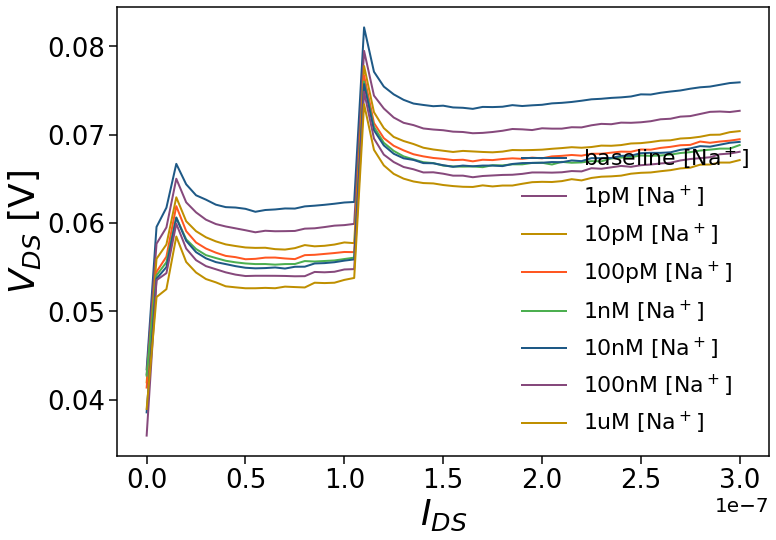

In [437]:
# plotting the 20 steps for the specific concentration

#subset_size = df1pM_.index.max()
#subset_dfs = [df1pM_.iloc[i:i + subset_size] for i in range(0, len(df1pM_), subset_size)] # we need this when we read_csv
colors = ['#1E5986', '#86497C', '#BF8F00', '#FF5722', '#4CAF50','#1E5986', '#86497C', '#BF8F00', '#FF5722', '#4CAF50']



fig, ax = plt.subplots(figsize = (11.69,8.26))
ax.tick_params(axis='both', width=1.5, length=8, labelsize=26)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
for i,concen in enumerate(conc):
    #ax.scatter(diode_dict_list[concen][15].index, (diode_dict_list[concen][15:]['VDL'].mean()-diode_dict_list[concen][15:]['VDR'].mean())*1000, label = 'conc:'+str(concen), color = colors_diff[i])
    ax.plot(diode_dict_list[concen][15]['IDL'], average_5sweeps_diff[concen]/1000, label =str(concen)+' [Na$^+]$', color = colors[i], linewidth = 2)
ax.set_xlabel('$I_{DS}$', fontsize = 36)
ax.set_ylabel('$V_{DS}$ [V]', fontsize = 36)
ax.legend( fontsize=22, frameon=False)
#plt.title('VDL-VDR across concentrations - Average of the last 6 sweeps curves')
#plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\VthShift_Na.jpg")
plt.show()

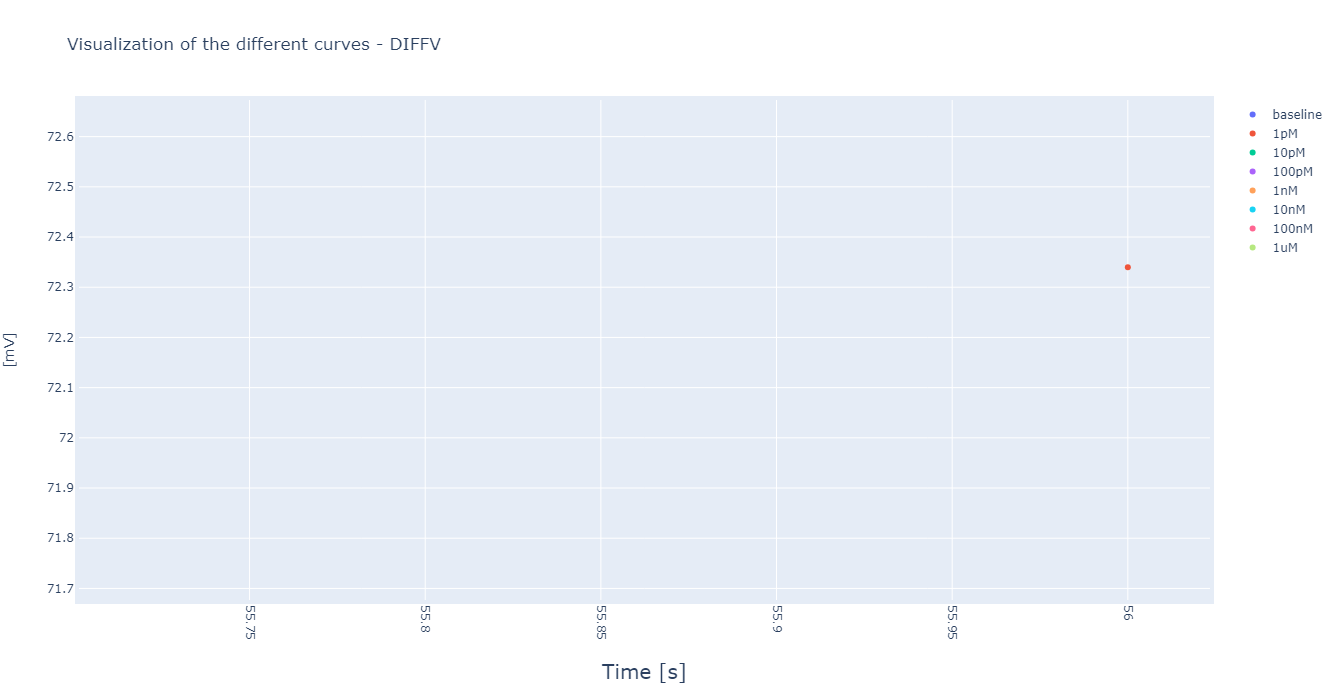

<Figure size 720x720 with 0 Axes>

In [439]:
plt.figure(figsize=(10,10))
fig = go.Figure()
x = average_5sweeps_diff
fig.add_traces([go.Scatter(x=x.index, y=x[i], mode='markers',name = i) for i in conc])

fig.update_layout(
    autosize=False,
    width=1200,
    height=700,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    title = 'Visualization of the different curves - DIFFV'
)

fig.update_xaxes(
        tickangle = 90,
        title_text = "Time [s]",
        title_font = {"size": 20},
        title_standoff = 25)

fig.update_yaxes(
        title_text = "[mV]",
        title_standoff = 25)
#plt.savefig(r'C:\Users\Desi\Desktop\TesiStanford\Nasensing\MaxDiffVAcrossConcentrations.png')
fig.show()

In [111]:
colors_L = sns.color_palette("Blues",3)
colors_R = sns.color_palette("YlOrBr",3)

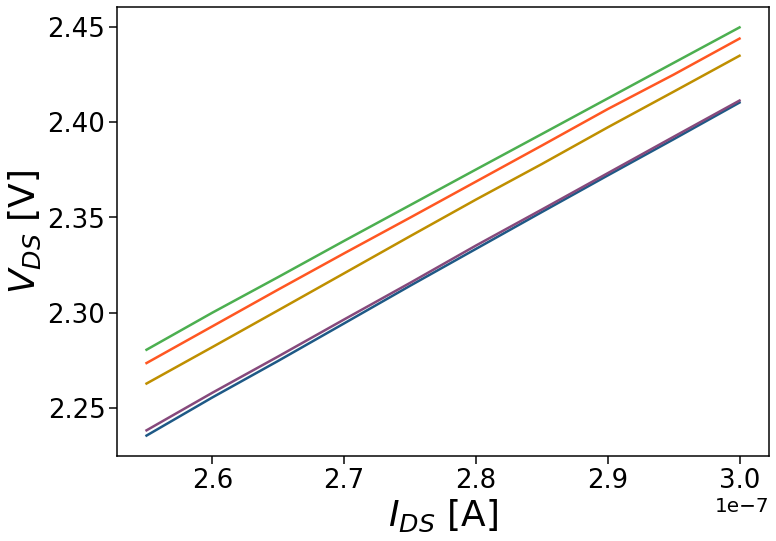

In [331]:
fig, ax = plt.subplots(figsize = (11.69,8.26))
ax.tick_params(axis='both', width=1.5, length=8, labelsize=26)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
#for i,df in enumerate(subset_dfs):
for i,concen in enumerate(conc):
    ax.plot(lists_of_df[i][-1]['IDL'].iloc[-10:],average_5sweeps[conc[i]].iloc[-10:]/1000, label = 'conc:'+str(conc[i]), color = colors[i], linewidth = 2.5)
    #ax.plot(lists_of_df[concen][-1]['IDR'].iloc[-10:], (lists_of_df[concen][-1]['VDR'].iloc[-10:])*1000, label = 'R_conc:'+str(conc[:-1][concen]), color = colors_R[i], linewidth = 2.5)

ax.set_xlabel('$I_{DS}$ [A]',fontsize = 36)
ax.set_ylabel('$V_{DS}$ [V]',fontsize = 36)
#ax.legend( fontsize=22, frameon=False)
#plt.title('VDL-VDR from 1 pM to 1 uM',fontsize = 15)
plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\VthShift_zoom_Na.jpg")
plt.show()

In [149]:
mean_std

[[0.0, 0.007302234056932375],
 [0.014496666666666692, 0.004656055793861921],
 [0.027836666666666704, 0.0008101371625978681],
 [0.04262999999999999, 0.004956281087894677],
 [0.051899999999999974, 0.004873419971870113],
 [0.06413666666666669, 0.0020686039307277206]]

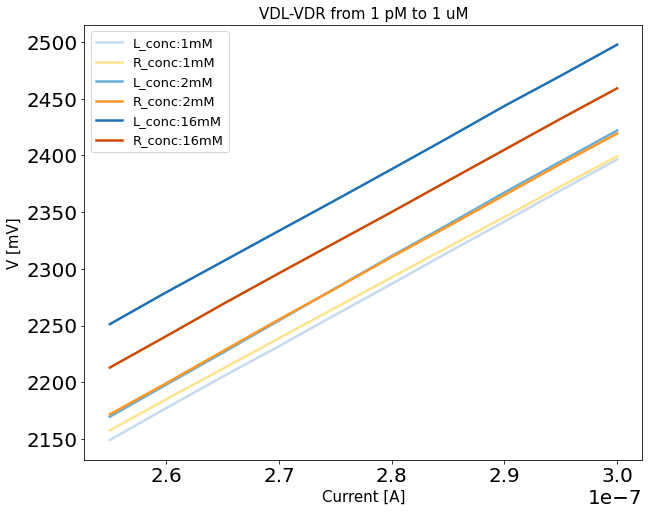

In [127]:
fig, ax = plt.subplots(figsize = (10,8))
#for i,df in enumerate(subset_dfs):
for i,concen in enumerate([1,2,-1]):
    ax.plot(lists_of_df[concen][-1]['IDL'].iloc[-10:], (lists_of_df[concen][-1]['VDL'].iloc[-10:])*1000, label = 'L_conc:'+str(conc[:-1][concen]), color = colors_L[i], linewidth = 2.5)
    ax.plot(lists_of_df[concen][-1]['IDR'].iloc[-10:], (lists_of_df[concen][-1]['VDR'].iloc[-10:])*1000, label = 'R_conc:'+str(conc[:-1][concen]), color = colors_R[i], linewidth = 2.5)

ax.set_xlabel('Current [A]',fontsize = 15)
ax.set_ylabel('V [mV]',fontsize = 15)
ax.legend(fontsize = 13)
plt.title('VDL-VDR from 1 pM to 1 uM',fontsize = 15)
plt.rcParams.update({'font.size': 20})
plt.show()

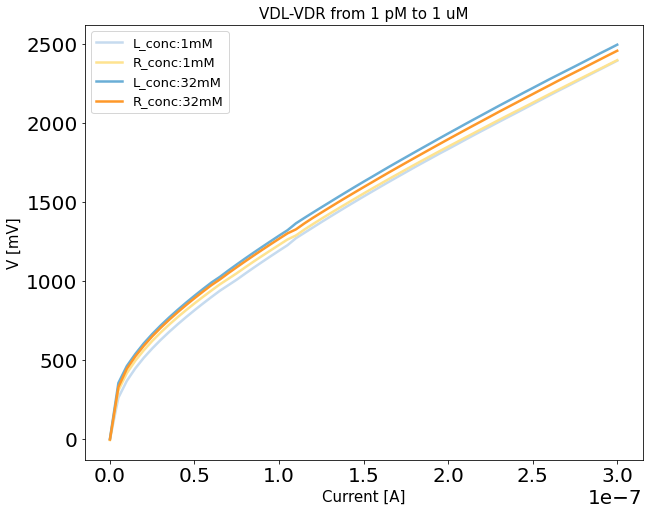

In [131]:
fig, ax = plt.subplots(figsize = (10,8))
#for i,df in enumerate(subset_dfs):
for i,concen in enumerate([1,-1]):
    ax.plot(lists_of_df[concen][-1]['IDL'], (lists_of_df[concen][-1]['VDL'])*1000, label = 'L_conc:'+str(conc[concen]), color = colors_L[i], linewidth = 2.5)
    ax.plot(lists_of_df[concen][-1]['IDR'], (lists_of_df[concen][-1]['VDR'])*1000, label = 'R_conc:'+str(conc[concen]), color = colors_R[i], linewidth = 2.5)

ax.set_xlabel('Current [A]',fontsize = 15)
ax.set_ylabel('V [mV]',fontsize = 15)
ax.legend(fontsize = 13)
plt.title('VDL-VDR from 1 pM to 1 uM',fontsize = 15)
plt.rcParams.update({'font.size': 20})
plt.show()

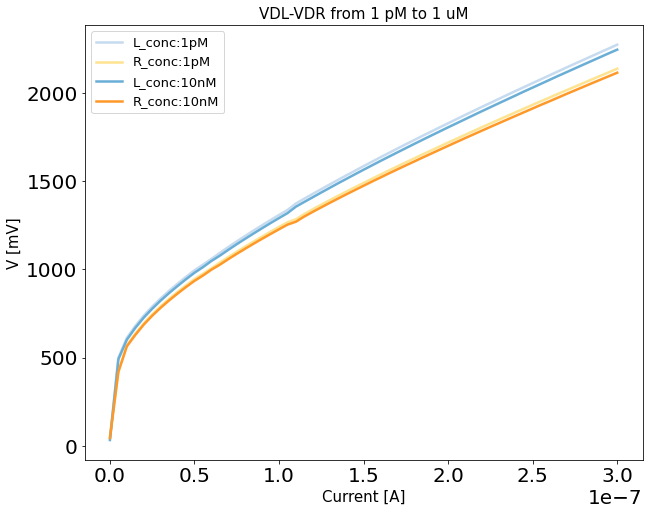

In [32]:
fig, ax = plt.subplots(figsize = (10,8))
#for i,df in enumerate(subset_dfs):
for i,concen in enumerate([1,-3]):
    ax.plot(lists_of_df[concen][-1]['IDL'], (lists_of_df[concen][-1]['VDL'])*1000, label = 'L_conc:'+str(conc[concen]), color = colors_L[i], linewidth = 2.5)
    ax.plot(lists_of_df[concen][-1]['IDR'], (lists_of_df[concen][-1]['VDR'])*1000, label = 'R_conc:'+str(conc[concen]), color = colors_R[i], linewidth = 2.5)

ax.set_xlabel('Current [A]',fontsize = 15)
ax.set_ylabel('V [mV]',fontsize = 15)
ax.legend(fontsize = 13)
plt.title('VDL-VDR from 1 pM to 1 uM',fontsize = 15)
plt.rcParams.update({'font.size': 20})
plt.show()

# End of code

In [80]:
df = pd.read_excel(str(os.getcwd())+'\\'+directory+'\\'+file)# for na sensing
df

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,Time,DrainI,DrainV,GateI,GateV,SRT
0,0.514088,-3.030306e-10,-5,2.158677e-10,2.00,0.000017
1,0.577227,-2.629754e-10,-5,4.379434e-10,1.95,0.000016
2,0.640364,-2.565186e-10,-5,4.335203e-10,1.90,0.000016
3,0.703510,-2.479412e-10,-5,4.300572e-10,1.85,0.000016
4,0.766646,-2.407269e-10,-5,4.023142e-10,1.80,0.000016
...,...,...,...,...,...,...
136,9.597686,-7.479576e-07,-5,-3.509361e-10,-4.80,0.000865
137,9.660930,-7.580761e-07,-5,-3.590329e-10,-4.85,0.000871
138,9.724154,-7.685005e-07,-5,-3.731993e-10,-4.90,0.000877
139,9.787433,-7.783005e-07,-5,-3.680295e-10,-4.95,0.000882


In [92]:
df_imp1

,GateV,DrainI-left,GateI-left,DrainI-right,GateI-right,IDSSQRT-left,IDSSQRT-right
0,2.0,1.288390e-10,6.947110e-11,4.475890e-10,1.754490e-10,0.01135,0.02116
1,1.9,1.272730e-10,1.893060e-11,4.179220e-10,1.987750e-10,0.01128,0.02044
2,1.8,1.147960e-10,2.842280e-11,3.929880e-10,1.885760e-10,0.01071,0.01982
3,1.7,1.097250e-10,4.337400e-11,3.602190e-10,1.621200e-10,0.01047,0.01898
4,1.6,1.068550e-10,4.877640e-11,3.239520e-10,1.695420e-10,0.01034,0.01800
...,...,...,...,...,...,...,...
137,1.6,9.332810e-11,7.416670e-11,4.158350e-10,1.936250e-10,0.00966,0.02039
138,1.7,9.595450e-11,1.211730e-10,4.365900e-10,2.259390e-10,0.00980,0.02089
139,1.8,9.746330e-11,1.352090e-10,4.620950e-10,2.281100e-10,0.00987,0.02150
140,1.9,9.935550e-11,2.361890e-10,4.813310e-10,2.204860e-10,0.00997,0.02194


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


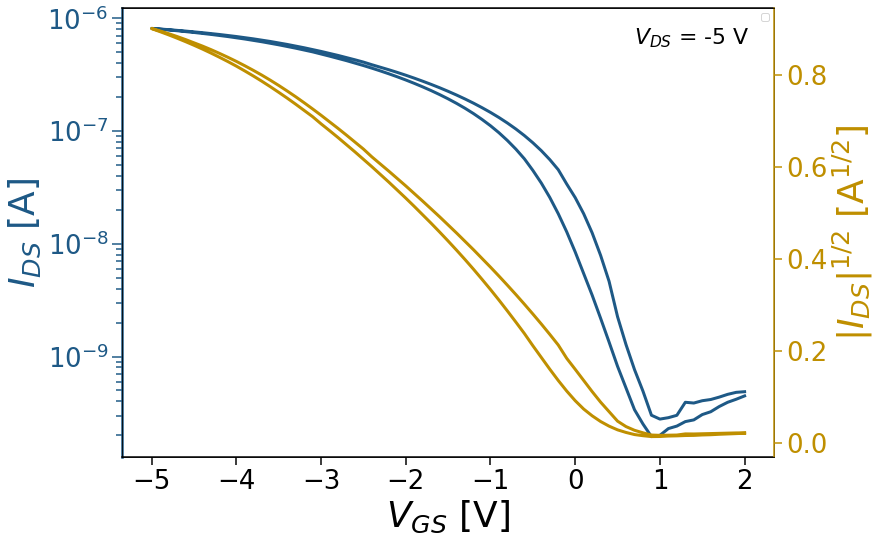

In [96]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

fig, ax1 = plt.subplots(figsize=(11.69, 8.26))
ax2 = ax1.twinx()
col_L = '#1E5986'
col_R= '#BF8F00'
# Modifica dello spessore delle linee degli assi principali
ax1.spines['bottom'].set_linewidth(1.5)
ax1.spines['top'].set_linewidth(1.5)
ax1.spines['left'].set_linewidth(2.5)
ax2.spines['right'].set_linewidth(1.5)

#ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
#ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))

# Modifica dello spessore e della lunghezza delle lineette minori degli assi
ax1.set_yscale('log')
ax1.tick_params(axis='y', width=1.5, length=10, which='major', labelsize=26, colors=col_L)  # Asse y sinistro
ax1.tick_params(axis='y', width=1.5, length=6, which='minor', labelsize=26, colors=col_L)  # Asse y sinistro
ax2.tick_params(axis='y', width=1.5, length=8, which='major', labelsize=26, colors=col_R)  # Asse y destro
ax1.tick_params(axis='x', width=1.5, length=8, which='major', labelsize=26,colors='black')  # Asse x

# Modifica del colore delle linee degli assi
ax1.spines['left'].set_color(col_L)
ax2.spines['right'].set_color(col_R)
ax1.spines['bottom'].set_color('black')  # Impostazione del colore dell'asse x a nero

# Plot delle linee

ax1.plot(df_imp1['GateV'], abs(df_imp1['DrainI-right']), color=col_L, linewidth=3)
#ax1.plot(df['GateV'], abs(df['GateI']), '--', color='#1E5986', linewidth=1.5, label='$I_G$')
ax2.plot(df_imp1['GateV'], abs(df_imp1['IDSSQRT-right']), color=col_R, linewidth=3)

# Etichette degli assi
ax1.set_xlabel('$V_{GS}$ [V]', fontsize=36)
ax1.set_ylabel('$I_{DS}$ [A]', fontsize=36, color=col_L)  # Etichetta asse y sinistro
ax2.set_ylabel('$|I_{DS}|^{1/2}$ [A$^{1/2}$]', fontsize=36, color=col_R)  # Etichetta asse y destro

# Legenda
plt.legend()
# Aggiungi testo al plot
plt.text(0.87, 0.82, '$V_{DS}$ = -5 V', fontsize=22, ha='right', transform=fig.transFigure)


#plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\OutputcurveOFET_wear2.jpeg",bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


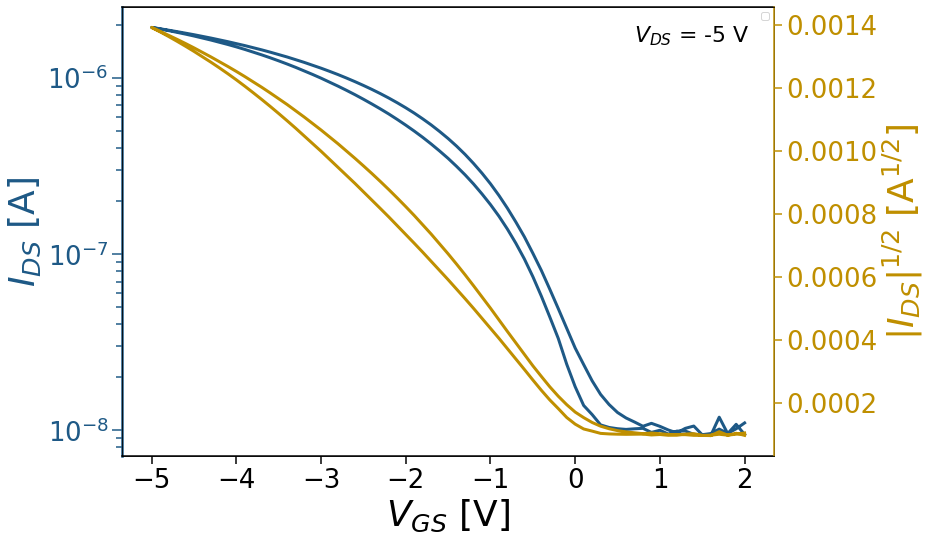

In [98]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

fig, ax1 = plt.subplots(figsize=(11.69, 8.26))
ax2 = ax1.twinx()
col_L = '#1E5986'
col_R= '#BF8F00'
# Modifica dello spessore delle linee degli assi principali
ax1.spines['bottom'].set_linewidth(1.5)
ax1.spines['top'].set_linewidth(1.5)
ax1.spines['left'].set_linewidth(2.5)
ax2.spines['right'].set_linewidth(1.5)

#ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
#ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))

# Modifica dello spessore e della lunghezza delle lineette minori degli assi
ax1.set_yscale('log')
ax1.tick_params(axis='y', width=1.5, length=10, which='major', labelsize=26, colors=col_L)  # Asse y sinistro
ax1.tick_params(axis='y', width=1.5, length=6, which='minor', labelsize=26, colors=col_L)  # Asse y sinistro
ax2.tick_params(axis='y', width=1.5, length=8, which='major', labelsize=26, colors=col_R)  # Asse y destro
ax1.tick_params(axis='x', width=1.5, length=8, which='major', labelsize=26,colors='black')  # Asse x

# Modifica del colore delle linee degli assi
ax1.spines['left'].set_color(col_L)
ax2.spines['right'].set_color(col_R)
ax1.spines['bottom'].set_color('black')  # Impostazione del colore dell'asse x a nero

# Plot delle linee
for x in list_df[2:3]:
    ax1.plot(x['GateV'], abs(x['DrainI']), color=col_L, linewidth=3)
    #ax1.plot(df['GateV'], abs(df['GateI']), '--', color='#1E5986', linewidth=1.5, label='$I_G$')
    ax2.plot(x['GateV'], abs(x['IDSSQRT']), color=col_R, linewidth=3)

# Etichette degli assi
ax1.set_xlabel('$V_{GS}$ [V]', fontsize=36)
ax1.set_ylabel('$I_{DS}$ [A]', fontsize=36, color=col_L)  # Etichetta asse y sinistro
ax2.set_ylabel('$|I_{DS}|^{1/2}$ [A$^{1/2}$]', fontsize=36, color=col_R)  # Etichetta asse y destro

# Legenda
plt.legend()
# Aggiungi testo al plot
plt.text(0.87, 0.82, '$V_{DS}$ = -5 V', fontsize=22, ha='right', transform=fig.transFigure)


#plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\OutputcurveOFET_wear2.jpeg",bbox_inches='tight')
plt.show()

In [62]:
df_wear4['IDSSQRT'] = df_wear4['SRT'] 

In [82]:
#df_imp1 = df
df_imp2 = df
#df_wear1 = df
#df_wear2 = df
#df_wear3 = df
#df_wear4 = df

In [73]:
df_imp1

,GateV,DrainI-left,GateI-left,DrainI-right,GateI-right,IDSSQRT-left,IDSSQRT-right
0,2.0,1.288390e-10,6.947110e-11,4.475890e-10,1.754490e-10,0.01135,0.02116
1,1.9,1.272730e-10,1.893060e-11,4.179220e-10,1.987750e-10,0.01128,0.02044
2,1.8,1.147960e-10,2.842280e-11,3.929880e-10,1.885760e-10,0.01071,0.01982
3,1.7,1.097250e-10,4.337400e-11,3.602190e-10,1.621200e-10,0.01047,0.01898
4,1.6,1.068550e-10,4.877640e-11,3.239520e-10,1.695420e-10,0.01034,0.01800
...,...,...,...,...,...,...,...
137,1.6,9.332810e-11,7.416670e-11,4.158350e-10,1.936250e-10,0.00966,0.02039
138,1.7,9.595450e-11,1.211730e-10,4.365900e-10,2.259390e-10,0.00980,0.02089
139,1.8,9.746330e-11,1.352090e-10,4.620950e-10,2.281100e-10,0.00987,0.02150
140,1.9,9.935550e-11,2.361890e-10,4.813310e-10,2.204860e-10,0.00997,0.02194


In [63]:
writer = ExcelWriter(os.getcwd()+'/electrical_characterization_wear.xlsx')
list_df = [df_wear1,df_wear2,df_wear3,df_wear4]
for key, df in enumerate(list_df):
    list_df[key].to_excel(writer, sheet_name="step #" + str(key))
writer.close()

In [60]:
np.mean([np.max(abs(i['DrainI'])) for i in list_df])
np.std([np.max(abs(i['DrainI'])) for i in list_df])

7.834342028871162e-07

In [50]:
#max I_DS
print(np.mean([np.max(abs(df_wear1['DrainI'])),np.max(abs(df_wear2['DrainI'])),np.max(abs(df_wear3['DrainI']))]))
print(np.std([np.max(abs(df_wear1['DrainI'])),np.max(abs(df_wear2['DrainI'])),np.max(abs(df_wear3['DrainI']))]))

1.2770702255693323e-06
4.69410193367098e-07


In [77]:
# hysteresis
print(np.mean([np.mean(abs(df_wear1['DrainI'].groupby(df_wear1[df_wear1['GateV']<-0.5]['GateV']).diff())),np.mean(abs(df_wear2['DrainI'].groupby(df_wear2[df_wear1['GateV']<-0.5]['GateV']).diff())),np.mean(abs(df_wear3['DrainI'].groupby(df_wear3[df_wear1['GateV']<-0.5]['GateV']).diff()))]))
print(np.std([np.mean(abs(df_wear1['DrainI'].groupby(df_wear1[df_wear1['GateV']<-0.5]['GateV']).diff())),np.mean(abs(df_wear2['DrainI'].groupby(df_wear2[df_wear1['GateV']<-0.5]['GateV']).diff())),np.mean(abs(df_wear3['DrainI'].groupby(df_wear3[df_wear1['GateV']<-0.5]['GateV']).diff()))]))


3.817274887296662e-08
3.67251692259551e-08


In [69]:
[np.max(abs(df_wear1['DrainI'].groupby(df_wear1[df_wear1['GateV']<-0.5]['GateV']).diff())),np.max(abs(df_wear2['DrainI'].groupby(df_wear2[df_wear1['GateV']<-0.5]['GateV']).diff())),np.max(abs(df_wear3['DrainI'].groupby(df_wear3[df_wear1['GateV']<-0.5]['GateV']).diff()))]

[2.817847644109861e-08, 1.3771398243989097e-08, 1.4986136420702678e-07]

In [72]:
#max I_GS
print(np.mean([np.max(abs(i['GateI'])) for i in list_df[:-1]]))
print(np.std([np.max(abs(i['GateI'])) for i in list_df][:-1]))

2.368251705853197e-09
1.4160178457009835e-09


In [91]:
#IMPLANTABLE
print('mean max:',np.mean([np.max(df_imp1['DrainI-right']),np.max(df_imp1['DrainI-left']),np.max(abs(df_imp2['DrainI']))]))
print('std max:',np.std([np.max(df_imp1['DrainI-right']),np.max(df_imp1['DrainI-left']),np.max(abs(df_imp2['DrainI']))]))
print('mean hyst:',np.mean([np.mean(df_imp1['DrainI-right'].groupby(df_imp1['GateV']).diff()),np.mean(df_imp1['DrainI-left'].groupby(df_imp1['GateV']).diff())]))
print('std hyst:',np.std([np.mean(df_imp1['DrainI-right'].groupby(df_imp1['GateV']).diff()),np.mean(df_imp1['DrainI-left'].groupby(df_imp1['GateV']).diff())]))
print(np.mean([np.max(df_imp1['GateI-right']),np.max(df_imp1['GateI-left']),np.max(df_imp2['GateI'])]))
print(np.std([np.max(df_imp1['GateI-right']),np.max(df_imp1['GateI-left']),np.max(df_imp2['GateI'])]))

mean max: 8.13187717590882e-07
std max: 2.139656782782089e-08
mean hyst: 2.514100589295775e-08
std hyst: 7.375499963380278e-09
3.0094946792126544e-10
9.691737125156531e-11


In [7]:
#wearable
print(np.max(abs(df['DrainI'])))
print(np.max(abs(df['DrainI'].groupby(df['GateV']).diff())))
print(np.max(abs(df['GateI'])))

1.0010733149101725e-06
2.817847644109861e-08
1.460465637315167e-09


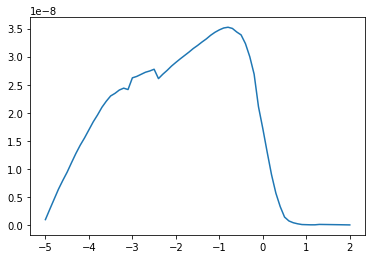

In [63]:
plt.plot(df['GateV'],abs(df['DrainI-right'].groupby(df['GateV']).diff()))

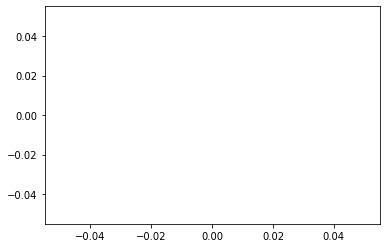

In [69]:
plt.plot(df['GateV'],abs(df['GateV'].groupby(df['DrainI-right']).diff()))

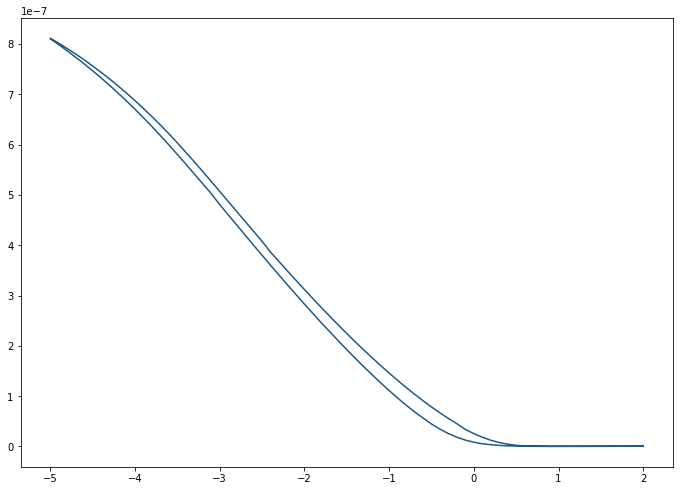

In [64]:
fig, ax1 = plt.subplots(figsize=(11.69, 8.26))
plt.plot(df['GateV'],abs(df['DrainI-right']), color = col_L)

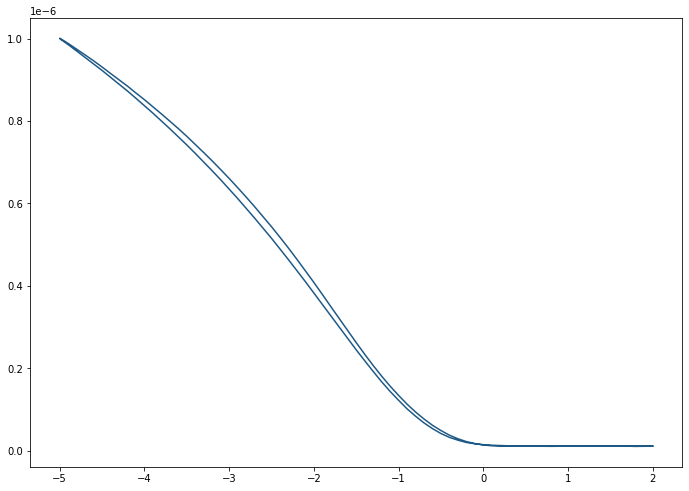

In [49]:
fig, ax1 = plt.subplots(figsize=(11.69, 8.26))
plt.plot(df['GateV'],abs(df['DrainI']), color = col_L)
#

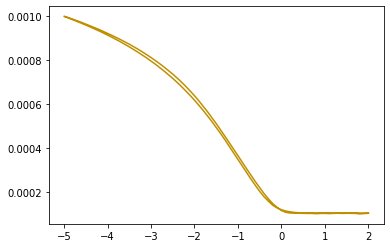

In [108]:
plt.plot(df_wear1['GateV'],abs(df_wear1['IDSSQRT']), color = col_R)

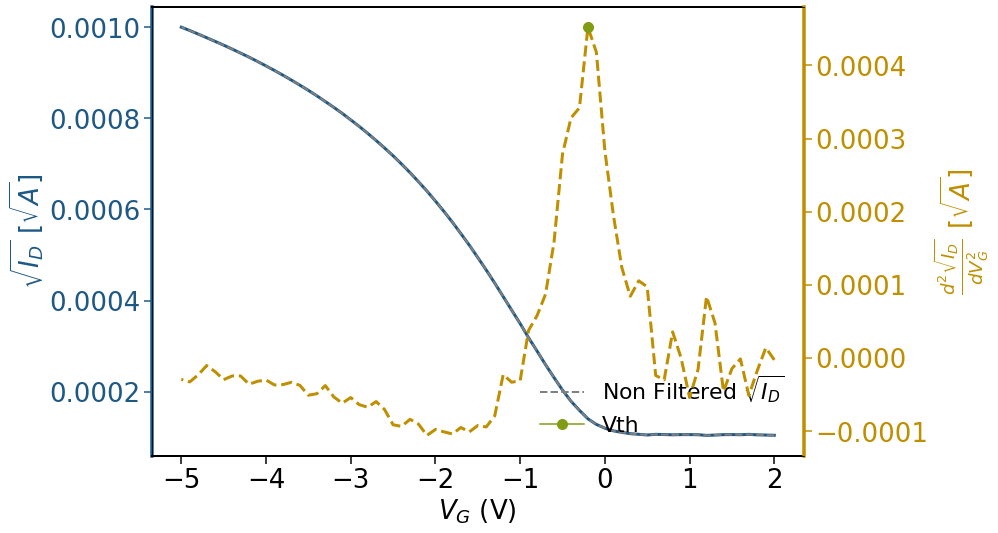

-0.20000002566110597


In [109]:
datay = abs(df_wear1['DrainI'].iloc[:round(len(df_wear1)/2)])
datax = df_wear1['GateV'].iloc[:round(len(df_wear1)/2)]
from scipy.signal import butter, filtfilt

IdS_sqrt = np.sqrt(datay)
vgs = datax


#applying 5th order butterworth filter to eliminate the measurement noise
cutoff_freq = 16

# Nyquist frequency
nyquist_freq = 0.5 * len(IdS_sqrt)
normalized_cutoff_freq = cutoff_freq / nyquist_freq

# coeficcient for the filter
b, a = butter(5, normalized_cutoff_freq, btype='low', analog=False)

# applying filter
vgs = filtfilt(b, a, vgs)
#IdS_filtered = savgol_filter(IdS_, window_length=15, polyorder=3, mode='nearest')

# max derivative point
IdS_ = np.gradient(np.gradient(IdS_sqrt,vgs),vgs)

# cut frequency of LPF

index_max_derivative = np.argmax(IdS_[:-10])
Vth = vgs[index_max_derivative]


fig, ax1 = plt.subplots(figsize=(11.69, 8.26))
ax2 = ax1.twinx()

# Imposta lo spessore delle linee degli assi
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['left'].set_linewidth(3.5)
ax2.spines['right'].set_linewidth(3.5)

ax1.spines['left'].set_color(col_L)
ax2.spines['right'].set_color(col_R)

# Plot delle curve con i colori desiderati
ax1.plot(vgs, IdS_sqrt, color=col_L, linewidth=3)
ax1.plot(datax, IdS_sqrt, '--', color='grey', label='Non Filtered $\sqrt{I_{D}}$', linewidth=2)
ax2.plot(vgs, IdS_, '--', color=col_R, linewidth=3)

# Imposta i parametri delle label e delle linee degli assi y
ax1.tick_params(axis='y', width=1.5, length=8, labelsize=26, labelcolor=col_L, colors=col_L)
ax1.tick_params(axis='x', width=1.5, length=8, labelsize=26)
ax2.tick_params(axis='y', width=1.5, length=8, labelsize=26, labelcolor=col_R, colors=col_R)

# Imposta i label degli assi e le unità di misura
ax1.set_xlabel('$V_{G}$ (V)', fontsize=26)
ax1.set_ylabel('$\sqrt{I_{D}}$ $[\sqrt{A}]$', fontsize=26, color=col_L)
ax2.set_ylabel(r'$\frac{d^2{\sqrt{I_{D}}}}{dV_G^2}$ $[\sqrt{A}]$', fontsize=26, color=col_R)

# Imposta i limiti degli assi y

# Plot del marker per Vth
ax2.plot(Vth, IdS_[index_max_derivative], marker="o", color='#809c13', label='Vth', markersize=10)

# Crea la legenda combinando le label di entrambi gli assi
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower right', fontsize=22, frameon=False)


#plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\SecondDerivative.jpeg",bbox_inches='tight')
plt.show()
print(Vth)





In [ ]:
#imp vth = 0.1
#wear vth = -0.2

In [112]:
i = 1.28e-6
w_l = 30
vgs = -5
vth = -0.2
C = 47e-9

mu_w = (2*i)/(C * w_l * (vgs-vth)**2)
mu_w

0.07880220646178095

In [114]:
i = 813e-9
w_l = 10
vgs = -5
vth = 0.1
C = 47e-9

mu_i = (2*i)/(C * w_l * (vgs-vth)**2)
mu_i

0.13300939900365655

#### Cortisol response

In [241]:

mean_std_CT = pd.DataFrame(mean_std).rename(columns={0: 'mean [mV]_Diff OFET (CT-5HT)', 1: 'std [mV]_Diff OFET (CT-5HT)'})

In [249]:
#mean_std_CT = pd.DataFrame(mean_std).rename(columns={0: 'mean Diff OFET (CT-5HT)  [mV]', 1: 'std Diff OFET (CT-5HT)  [mV]'})
mean_std_CT['mean [mV]_Diff OFET (CT-MT)'] = [i[0]-mean_std[0][0] for i in mean_std]
mean_std_CT['std [mV]_Diff OFET (CT-MT)'] = [i[1] for i in mean_std]
index_map = dict(zip(mean_std_CT.index, conc))

# Rinomina gli indici utilizzando il metodo rename
mean_std_CT = mean_std_CT.rename(index=index_map)
#mean_std_CT = mean_std_CT.transpose()

In [251]:
# Funzione per colorare gli indici
mean_std_CT
nomi_colonne = mean_std_CT.columns.tolist()

# Dividi i nomi delle colonne in base ai delimitatori
nomi_suddivisi = [nome.split('_') for nome in nomi_colonne]

# Estrai orientazioni e statistiche
orientazioni = [nome[0] for nome in nomi_suddivisi]
statistiche = [nome[1].split(' [')[0] for nome in nomi_suddivisi]

# Crea il MultiIndex
multi_indice = pd.MultiIndex.from_arrays([statistiche, orientazioni])

# Assegna il MultiIndex alle colonne del DataFrame
mean_std_CT.columns = multi_indice


In [252]:
mean_std_CT

Diff OFET (CT-5HT)           Diff OFET (CT-MT)          
             mean [mV]       std [mV]     mean [mV]      std [mV]
baseline      0.000000       0.382172      0.000000      0.719228
1pM          -0.643333       0.278727     -3.243333      0.419325
10pM         -1.960000       0.463669     -5.693333      0.268576
100pM        -2.576667       0.413602     -6.580000      0.419629
1nM          -4.596667       0.347179     -7.473333      0.678921
10nM         -4.800000       0.509171     -6.950000      0.287615
100nM        -6.490000       0.616838     -8.113333      0.334265
1uM          -8.160000       0.803361     -8.916667      0.675220

In [260]:
styles = {
    ('Diff OFET (CT-5HT)', 'mean [mV]'): [{'selector': '', 'props': [('background-color', 'rgba(30, 89, 134, 0.15)')]}],
    ('Diff OFET (CT-5HT)', 'std [mV]'): [{'selector': '', 'props': [('background-color',  'rgba(30, 89, 134, 0.15)')]}],
    ('Diff OFET (CT-MT)', 'mean [mV]'): [{'selector': '', 'props': [('background-color', ' rgba(191, 143, 0, 0.15)')]}],
    ('Diff OFET (CT-MT)', 'std [mV]'): [{'selector': '', 'props': [('background-color', ' rgba(191, 143, 0, 0.15)')]}],

}

styled_df = mean_std_CT.style.set_table_styles(styles)

# Applica stili agli indici
styled_df = styled_df.set_properties(**{'background-color': 'rgba(200, 200, 200, 0.3)'})

styled_df.set_properties(**{'text-align': 'center'})
pd.set_option('colheader_justify', 'center')

In [261]:
styled_df = styled_df.format("{:.3f}")
import dataframe_image as dfi

dfi.export(styled_df, r'C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\CT_styled.png')

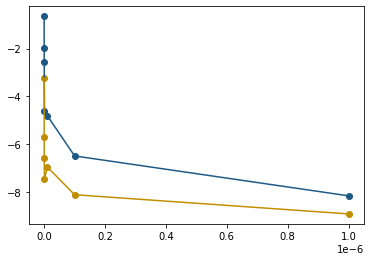

In [115]:
plt.scatter( [1e-12,10e-12,100e-12,1e-9,10e-9,100e-9,1e-6], y, color = col_L)
plt.plot( [1e-12,10e-12,100e-12,1e-9,10e-9,100e-9,1e-6], y, color = col_L)
plt.scatter([1e-12,10e-12,100e-12,1e-9,10e-9,100e-9,1e-6], y_mt, color = col_R)
plt.plot([1e-12,10e-12,100e-12,1e-9,10e-9,100e-9,1e-6], y_mt, color = col_R)

In [103]:
np.log([0,1,10,100,1e3,10e3,100e3,1e6])

C:\Users\Desi\AppData\Local\Temp\ipykernel_22252\3065941015.py:1: RuntimeWarning: divide by zero encountered in log
  np.log([0,1,10,100,1e3,10e3,100e3,1e6])


array([       -inf,  0.        ,  2.30258509,  4.60517019,  6.90775528,
        9.21034037, 11.51292546, 13.81551056])

In [139]:
(y_5ht[1]-y_5ht[0])

-1.3167

In [144]:
(y_mt[-1]-y_mt[-2])

-0.8036999999999992

In [142]:
(y_5ht[-1]-y_5ht[0])/6

-1.2527833333333334

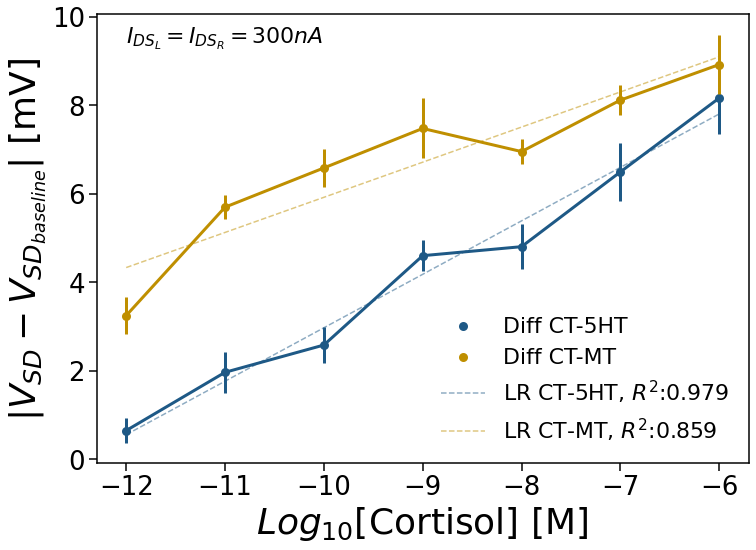

In [238]:
# regression CT-5HT

conc_scale = [1e-12,10e-12,100e-12,1e-9,10e-9,100e-9,1e-6]
y_5ht = np.array([-0.6433,-1.96,-2.5767,-4.5967,-4.8,-6.49,-8.16])
y_mt = np.array([-3.243,-5.693,-6.58,-7.473,-6.95,-8.1133,-8.917])
std_5ht = [0.2787,0.4636,0.4136,0.3471,0.5092,0.66168,0.8033]
std_mt = [0.419325,0.26856,0.4196,0.6789,0.2876,0.334265,0.6752]

m_5ht,q_5ht = np.polyfit(np.log10(conc_scale), y_5ht, 1)
m_mt,q_mt = np.polyfit(np.log10(conc_scale), y_mt, 1)

# Calcolare la retta di regressione
line_5ht = m_5ht * np.log10(conc_scale) + q_5ht
line_mt = m_mt * np.log10(conc_scale) + q_mt
# Calcolare il coefficiente di correlazione (R-squared)
correlation_matrix_5ht = np.corrcoef( np.log10(conc_scale),  y_5ht)
correlation_xy_5ht = correlation_matrix_5ht[0,1]
r_squared_5ht = correlation_xy_5ht**2

correlation_matrix_mt = np.corrcoef( np.log10(conc_scale),  y_mt)
correlation_xy_mt = correlation_matrix_mt[0,1]
r_squared_mt = correlation_xy_mt**2

# Visualizzare i dati e la regressione

fig, ax = plt.subplots(figsize = (11.69,8.26))
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.tick_params(axis='both', width=1.5, length=8, labelsize=26)


plt.scatter( np.log10(conc_scale), abs(y_5ht), color = col_L, linewidth = 3, label = 'Diff CT-5HT')
plt.scatter( np.log10(conc_scale), abs(y_mt), color = col_R, linewidth = 3, label = 'Diff CT-MT')

plt.plot( np.log10(conc_scale), abs(line_5ht), '--', label='LR CT-5HT, $R^2$:'+str(round(r_squared_5ht,3)), color = (30/255, 89/255, 134/255, 0.5))
plt.errorbar( np.log10(conc_scale), abs(y_5ht), std_5ht, color = col_L, linewidth = 3)

plt.plot( np.log10(conc_scale), abs(line_mt), '--', label='LR CT-MT, $R^2$:'+str(round(r_squared_mt,3)), color = (191/255, 143/255, 0, 0.5))
plt.errorbar( np.log10(conc_scale), abs(y_mt),std_mt, color = col_R, linewidth = 3)

plt.text(-12, 9.4, '$I_{DS_L} = I_{DS_R} = 300 nA$', fontsize = 22)
plt.xlabel('$Log_{10}$[Cortisol] [M]', fontsize = 36)
plt.ylabel('$|V_{SD} - V_{SD_{baseline}}|$ [mV]', fontsize = 36)
plt.legend(loc = 'lower right', fontsize=22, frameon=False)
plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\Comp_responses_CT.jpeg",bbox_inches='tight')


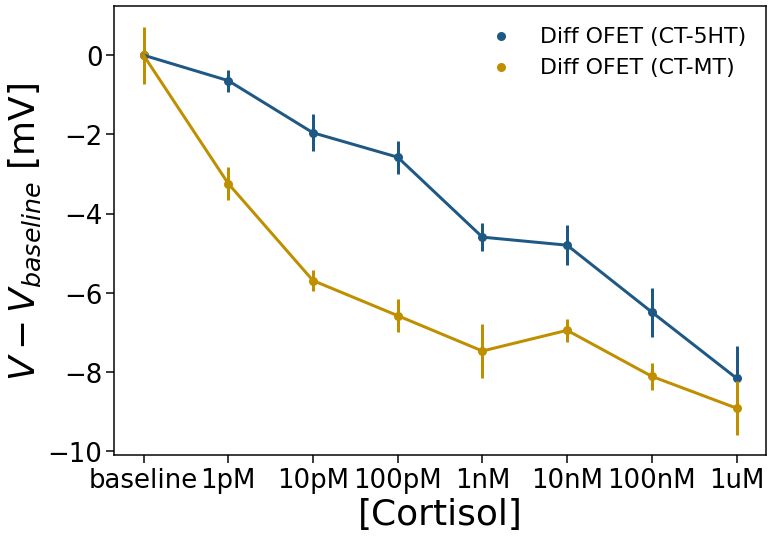

In [262]:
conc_ = conc
col_L = '#1E5986'
col_R = '#BF8F00'
col_diff = "#FF8080"
fig, ax = plt.subplots(figsize = (11.69,8.26))
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)


ax.tick_params(axis='both', width=1.5, length=8, labelsize=26)

plt.scatter(conc_, mean_std_CT['Diff OFET (CT-5HT)']['mean [mV]'] , color = col_L, linewidth = 3, label='Diff OFET (CT-5HT)')
plt.errorbar(conc_, mean_std_CT['Diff OFET (CT-5HT)']['mean [mV]'], yerr=mean_std_CT['Diff OFET (CT-5HT)']['std [mV]'], color = col_L, linewidth = 3)
plt.scatter(conc_, mean_std_CT['Diff OFET (CT-MT)']['mean [mV]'] , color = col_R, linewidth = 3, label='Diff OFET (CT-MT)')
plt.errorbar(conc_, mean_std_CT['Diff OFET (CT-MT)']['mean [mV]'], yerr=mean_std_CT['Diff OFET (CT-MT)']['std [mV]'], color = col_R, linewidth = 3)
plt.xlabel('[Cortisol]', fontsize = 36)
plt.ylabel('$V - V_{baseline}$ [mV]', fontsize = 36)
plt.legend( fontsize=22, frameon=False)
plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\Comp_responses_CT.jpeg",bbox_inches='tight')
#plt.title('Mean and Std DeltaV dor different concentrartions (last 5 values of the last 6 steps)')


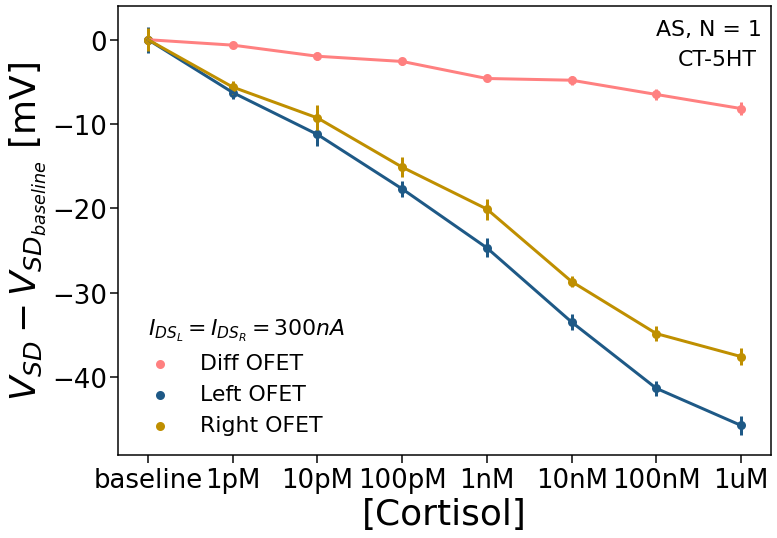

In [94]:
col_L = '#1E5986'
col_R = '#BF8F00'
col_diff = "#FF8080"
fig, ax = plt.subplots(figsize = (11.69,8.26))
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)


ax.tick_params(axis='both', width=1.5, length=8, labelsize=26)

L = [i[0] - mean_std_L[0][0] for i in mean_std_L]
R = [i[0] - mean_std_R[0][0] for i in mean_std_R]
# NA ['10','20','40','80','160']
plt.scatter(conc, [i[0] for i in mean_std], color = col_diff , linewidth = 3, label='Diff OFET')
plt.errorbar(conc, [i[0] for i in mean_std], yerr=[i[1] for i in mean_std], color = col_diff, linewidth = 3)
plt.scatter(conc, L , color = col_L, linewidth = 3, label='Left OFET')
plt.errorbar(conc, L, yerr=[i[1] for i in mean_std_L], color = col_L, linewidth = 3)
plt.scatter(conc, R , color = col_R, linewidth = 3, label='Right OFET')
plt.errorbar(conc, R, yerr=[i[1] for i in mean_std_R], color = col_R, linewidth = 3)
plt.text(6, 0.5, 'AS, N = 1', fontsize = 22)
plt.text(6.25, -3, 'CT-5HT', fontsize = 22)
plt.text(0, -35, '$I_{DS_L} = I_{DS_R} = 300 nA$', fontsize = 22)
plt.xlabel('[Cortisol]', fontsize = 36)
plt.ylabel('$V_{SD} - V_{SD_{baseline}}$ [mV]', fontsize = 36)
plt.legend(loc = 'lower left',  fontsize=22, frameon=False)
plt.savefig(r"C:\Users\Desi\Desktop\TesiStanford\ImagesThesis\CT_with5HT-sensing.jpeg",bbox_inches='tight')
#plt.title('Mean and Std DeltaV dor different concentrartions (last 5 values of the last 6 steps)')


#### saving the table in an xlsx file